### Проект: Улучшение baseline модели.

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️</h2>

Привет, Николай! Меня зовут Анжела Бурова, и сегодня я твой ревьюер. 

Для начала несколько организационных моментов:
При обнаружении у тебя в работе ошибки, в первый раз я лишь укажу на ее наличие и у тебя будет возможность самому найти её и исправить. В реальной работе твой начальник будет поступать также, а я пытаюсь подготовить тебя именно к работе Дата-инженера. Однако, если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку

По поводу моих комментов:
1. Я буду оставлять комментарии в Markdown-ячейках
2. Эти комментарии не должны удаляться или редактироваться тобой. На каждый мой комментарий отвечай пожалуйста новой Markdown-ячейке помечая другим цветом, если вопросов и предложений к поправкам нет - можно не отвечать.
3. Если я буду обновлять свои комментарии, я буду добавлять v2, v3 и т.д. к заголовку комментария. Тебе предлагаю также соблюдать версионирование комментариев.

Комментарии могут быть 3х типов, также как и раньше. 

- Зеленый комментарий с ✔️ (как этот) означает похвалу или развивющие советы.

</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

- Желтый комментарий с некритичным замечанием (можно лучше)

</div>
<div class="alert alert-danger">
<h2> Комментарий ревьюера ❌</h2>

- Красный комментарий с критической ошибкой

</div>


<div class="alert alert-warning">
<h2> Комментарий ревьюера по проекту⚠️</h2>

В целом у тебя хороший качественный проект, мне немного не хватило анализа в eda более глубокого. Но пока можно оставить так.
Сильно не хватило сравнения результатов моделей и выводов по ним. Давай сделаешь графики метрик после каждого этапа обучения модели и посмотрим какой есть рост-падение. Хочется увидеть какие то выводы, если падение, то почему, и что можно было бы сделать еще в теории.
    
Кроме того заметила что ты часто повторяешь кусочки кода одинаковые, во-первых не поняла почему после некоторых обучений ты по два раза делаешь ячейку с метриками. Во-вторых конечно достаточно даже 2х повторений кода чтобы понять, что нужна функция. Чтобы код выглядел более лаконично и красиво, нужно сделать функцию оценки модели и вызывать ее тогда, когда нужно.
    
    
Предлагаю доработать проект и жду его обратно)

</div>

Привет Анджела! Рад что ты опять ревьюешь мой проект! Спасибо что назвала хорошим и качественным :-).  у меня же если честно в момент работы над проектом возникло много вопросов )))
Спасибо за твои комментарии, я переработал несколько проект. Надеюсь, в таком виде он легче для восприятия.

Обучение и проверка модели проводится на датесете clat_cleaned_churn. 
Описание данных:

* **id** - уникальный id объекта
* **build_year** - год постройки 
* **building_type_int** - тип здания
* **latitude** - географическая широта
* **longitude** - географическая долгота
* **ceiling_height** - высота потолка
* **flats_count** - количество квартир в здании 
* **floors_total** - количество этажей в здании
* **has_elevator** - наличие лифта
* **floor** - этаж 
* **kitchen_area** - площадь кухни
* **living_area** - жилая площадь
* **rooms** - количество комнат 
* **is_apartment** - является ли помещение апартаментами
* **studio** - является ли помещение студией
* **total_area** - общая площадь
* **target** - целевая переменная (стоимость жилья)

Также уже располагаю базовой моделью, которую с помощью изученных инструментов планирую улучшить. 

In [13]:
!pip install mlxtend
import os
import mlflow
import time
import optuna
import psycopg2 as psycopg
import pandas as pd
import numpy as np
import psycopg
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler
from autofeat import AutoFeatRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, KBinsDiscretizer, MinMaxScaler
from sklearn.impute import SimpleImputer

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] =  os.getenv("AWS_SECRET_ACCESS_KEY")

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

# Установка URI для tracking и registry
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

TABLE_NAME = "flat_cleaned_churn"
RANDOM_STATE = 42



#### Этап 1: Разворачивание сервера mlflow и пробное логирование baseline model

In [15]:
EXPERIMENT_NAME = "Baseline model registration"
RUN_NAME = "Nick_projecr _run_1"

In [5]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]
    
df = pd.DataFrame(data, columns=columns)

In [6]:
columns_list = df.columns.tolist()
columns_text = ",".join(columns_list) 
with open("columns.txt", "w", encoding="utf-8") as fio:
    fio.write(columns_text)
    
df.to_csv("flat_cleaned_churn", index=False) 

In [7]:
# Исключение столбцов с меньше чем 2 уникальными значениями
unique_counts = df.nunique()
columns_to_drop = unique_counts[unique_counts < 2].index
df = df.drop(columns=columns_to_drop)
X = df.drop('target', axis=1).copy()
# Разделение данных на категориальные и числовые
cat_features = X.select_dtypes(include='object')
potential_binary_features = cat_features.nunique() == 2
binary_cat_features = cat_features[potential_binary_features[potential_binary_features].index]
other_cat_features = cat_features[potential_binary_features[~potential_binary_features].index]
num_features = X.select_dtypes(['float','int'])
date_features = X.select_dtypes(include='datetime64[ns]')

preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary'), binary_cat_features.columns.tolist()),
        ('cat', OneHotEncoder(handle_unknown='ignore'), other_cat_features.columns.tolist()),
        ('num', StandardScaler(), num_features.columns.tolist()),
        ('date', StandardScaler(), date_features.columns.tolist())  # Обработка признаков даты    
    ],
    remainder='drop', verbose_feature_names_out=False
    )


model = LinearRegression(fit_intercept=True)  
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
    )

y = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
pipeline.fit(X_train, y_train)

prediction = pipeline.predict(X_test)
print(prediction)

[ 9190400. 11100160. 11832320. ...  9726976.  9661440. 13307904.]


<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

random_state лучше фиксировать в константу в начале юпитера, т.к. есть шанс что потом будешь использовать ее.

</div>

Принято, понято, исправлено. Ниже заверну оценку метрик в функцию.

In [8]:
def plot_prediction_fact (X_test, y_test, model):
    prediction = model.predict(X_test)
    y_test_subset = y_test[:3505] 
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_subset, y=prediction, s=15, alpha=0.6)
    plt.title('График Прогноз-Факт')
    plt.ylabel('Прогноз')
    plt.xlabel('Факт')
    plt.show()

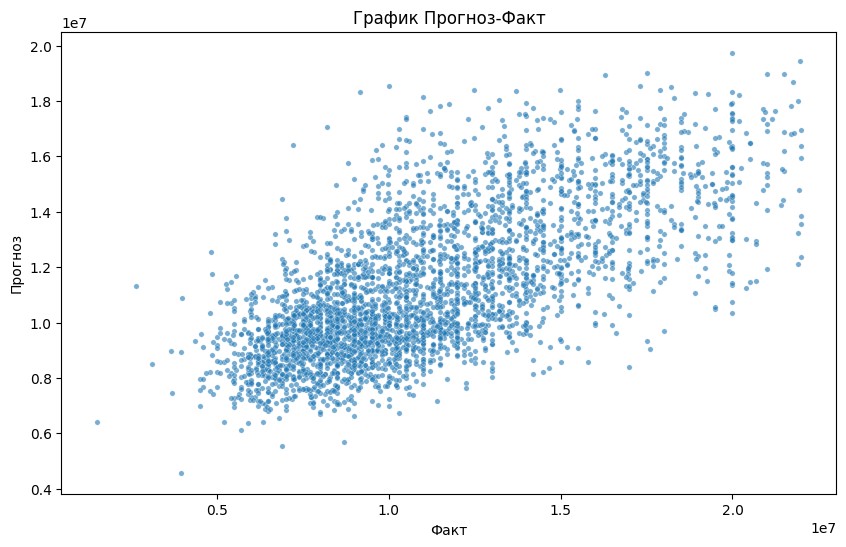

In [9]:
plot_prediction_fact (X_test, y_test, pipeline)

In [11]:
def evaluate(pipeline, X_test, y_test):
    start_time = time.time()
    prediction = pipeline.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    mean = y_test.mean()  # среднее значение целевой переменной на тесте
    MAE = mean_absolute_error(y_test, prediction)
    MSE = mean_squared_error(y_test, prediction)
    R2 = r2_score(y_test, prediction)
    y_error = y_test - prediction
    y_error_abs = abs(y_error)
    perc_error_abs = y_error_abs / y_test
    mape = perc_error_abs.mean()
    
    return {
        'Среднее значение целевой переменной': mean.round(2),
        'Средний модуль ошибки': MAE.round(2),
        'Средняя квадратичная ошибка': MSE.round(2),
        'Коэффициент детерминации': R2.round(2),
        'Средняя абсолютная ошибка в процентах': mape.round(2),
        'Время предсказания в секундах': prediction_time
    }


In [12]:
evaluation_results_baseline = evaluate(pipeline, X_test, y_test)
evaluation_results_baseline

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки': 2112425.53,
 'Средняя квадратичная ошибка': 7090022128548.31,
 'Коэффициент детерминации': 0.47,
 'Средняя абсолютная ошибка в процентах': 0.21,
 'Время предсказания в секундах': 0.010776996612548828}

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️</h2>

Хорошо, будем мониторить сразу несколько метрик. Молодец, что округлил, так намного удобнее будет на них смотреть)

</div>

In [17]:
REGISTRY_MODEL_NAME = "baseline_model_nikolaimelnikov"

pip_requirements = '../requirements.txt' # ваш код здесь
signature = mlflow.models.infer_signature(X_test, prediction)# ваш код здесь
input_example = input_example = X_test[:10]# ваш код здесь
metadata = {'model_type': 'monthly'}# ваш код здесь

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

model_path = "mlflow_baseline_model"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.sklearn.log_model(pipeline, model_path, pip_requirements=pip_requirements,
                             input_example=input_example, metadata=metadata, signature=signature,
                             registered_model_name=REGISTRY_MODEL_NAME, await_registration_for=6)

    # Дополнительные логгирования метрик и артефактов
    mlflow.log_metrics(evaluation_results_baseline)
    mlflow.log_artifact("columns.txt", artifact_path="dataframe")
    mlflow.log_artifact("flat_cleaned_churn", artifact_path="dataframe")

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Registered model 'baseline_model_nikolaimelnikov' already exists. Creating a new version of this model...
2024

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️</h2>

Первый этап принимаю, все хорошо)

</div>

#### Этап 2: Исследовательский Анализ Данных (EDA)


In [18]:
EXPERIMENT_NAME = "EDA and plots"
RUN_NAME = "Nick_project_EDA"
ASSETS_DIR = "assets"
os.mkdir(ASSETS_DIR)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Nick_projecr _eda - название странное :) пробел еще зачем то.
</div>


Подумал просто что название "Ник проект еда" звучит по меньшей мере романтично, но отчепятался каким то образом))). Исправил на более читаемое))). 

In [26]:
# 2.1. Общий обзор датасета
def df_info(df):
    display(df.sample(10))
    display(df.isna().sum())
    display(df.info())
    display(df.shape)
    display(df.describe())
df_info(df)

,id,build_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,target
6670,6671,13157,1980-01-01,4,55.891758,37.534782,2.64,72,9,true,2,5.8,34.099998,3,false,49.400002,12500000.0
585,586,16186,1995-01-01,4,55.615311,37.648258,2.64,134,17,true,8,8.5,19.000000,1,false,38.000000,6600000.0
2873,2874,6832,1966-01-01,6,55.810394,37.557907,2.64,92,12,true,11,6.4,21.799999,2,false,37.799999,9990000.0
10125,10126,3457,1960-01-01,4,55.800312,37.483894,2.64,70,5,false,4,9.0,28.000000,2,false,50.000000,17300000.0
7488,7489,16281,1995-01-01,4,55.654339,37.747440,2.64,279,7,true,7,9.0,48.000000,3,false,73.900002,11000000.0
12393,12394,10715,1974-01-01,1,55.794098,37.574112,2.70,151,9,true,7,10.5,34.500000,2,false,53.000000,14899900.0
2296,2297,4611,1962-01-01,6,55.712749,37.673286,2.64,70,9,true,7,7.5,20.600000,2,false,36.900002,11000000.0
15011,15012,11932,1977-01-01,4,55.595772,37.670746,2.70,111,16,true,10,11.0,28.000000,2,false,56.000000,8200000.0
13144,13145,15829,1993-01-01,4,55.587421,37.651566,2.70,193,15,true,13,8.0,31.000000,2,false,51.000000,9350000.0
9157,9158,8083,1968-01-01,6,55.845737,37.491898,2.64,84,12,true,1,5.7,29.600000,2,false,44.700001,12600000.0


id                   0
build_id             0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
total_area           0
target               0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 17521 non-null  int64         
 1   build_id           17521 non-null  int64         
 2   build_year         17521 non-null  datetime64[ns]
 3   building_type_int  17521 non-null  object        
 4   latitude           17521 non-null  float64       
 5   longitude          17521 non-null  float64       
 6   ceiling_height     17521 non-null  float64       
 7   flats_count        17521 non-null  int64         
 8   floors_total       17521 non-null  int64         
 9   has_elevator       17521 non-null  object        
 10  floor              17521 non-null  int64         
 11  kitchen_area       17521 non-null  float64       
 12  living_area        17521 non-null  float64       
 13  rooms              17521 non-null  int64         
 14  is_apa

None

(17521, 17)

,id,build_id,build_year,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,target
count,17521.000000,17521.000000,17521,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,1.752100e+04
mean,8761.000000,11347.842418,1978-11-29 00:30:44.278294656,55.738301,37.611767,2.685381,161.009703,11.550254,5.898065,8.257431,28.468097,1.888933,49.360562,1.122007e+07
min,1.000000,5.000000,1902-01-01 00:00:00,55.466152,37.200352,2.300000,1.000000,1.000000,1.000000,1.800000,0.000000,1.000000,12.650000,6.000000e+05
25%,4381.000000,5984.000000,1965-01-01 00:00:00,55.661861,37.511875,2.640000,80.000000,8.000000,3.000000,6.000000,19.799999,1.000000,38.000000,8.400000e+06
50%,8761.000000,10811.000000,1974-01-01 00:00:00,55.739178,37.599266,2.640000,128.000000,12.000000,5.000000,8.200000,28.799999,2.000000,45.099998,1.050000e+07
75%,13141.000000,16272.000000,1995-01-01 00:00:00,55.817577,37.727669,2.700000,215.000000,16.000000,8.000000,10.000000,35.000000,2.000000,58.099998,1.350000e+07
max,17521.000000,24620.000000,2023-01-01 00:00:00,56.009346,37.946411,3.250000,482.000000,27.000000,17.000000,15.900000,68.199997,5.000000,95.000000,2.224400e+07
std,5058.021369,6412.660787,NaN,0.100712,0.141077,0.152389,101.127958,5.002248,4.056324,2.138494,11.792972,0.769268,14.358618,3.724475e+06


In [20]:
#Проверяю дубликаты:
len(df[df.duplicated() == True])

0

In [56]:
#print(df['id'].unique()) 

In [21]:
#попробую найти одинаковые id
print('Квартир с одинаковым id:{}'. format(len(df[df.duplicated(['id']) == True])))

Квартир с одинаковым id:0


In [22]:
count_zero_living_area = df.query('living_area == 0').shape[0]
print('Количество строк, где значение столбца living_area равно 0:', count_zero_living_area)

Количество строк, где значение столбца living_area равно 0: 732


In [25]:
#df.query('living_area == 0')

In [27]:
zero_living_area_rows = df.query('living_area == 0')

difference = zero_living_area_rows['total_area'] - zero_living_area_rows['kitchen_area']

# Заменяю нулевые значения в living_area рассчитанными значениями, не допуская отрицательных значений
filled_values = difference.apply(lambda x: max(x, 0))
df.loc[zero_living_area_rows.index, 'living_area'] = filled_values

# Проверка наличия отрицательных значений после заполнения
if (df['living_area'] < 0).any():
    print('Обнаружены отрицательные значения после заполнения')
else:
    print('Значения успешно заполнены')

Значения успешно заполнены


In [45]:
#Дополню df новым признаком указывающим на возраст строения.
current_date = pd.Timestamp.now()

# Вычисляем возраст дома в годах
df['building_age'] = (current_date - df['build_year']) // np.timedelta64(1, 'Y')
df.sample(3)

,id,build_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,target,building_age
12638,12639,3727,1961-01-01,1,55.773388,37.582752,2.50,63,8,true,1,5.0,24.0,2,false,35.000000,14600000.0,63
6566,6567,12524,1978-01-01,6,55.756638,37.680672,2.48,111,16,true,9,11.0,29.0,2,false,51.000000,10450000.0,46
16099,16100,10819,1974-01-01,4,55.678307,37.452999,2.64,212,9,true,3,6.1,28.0,2,false,44.599998,9790000.0,50


2024-05-16 11:19:44,034 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-16 11:19:44,044 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


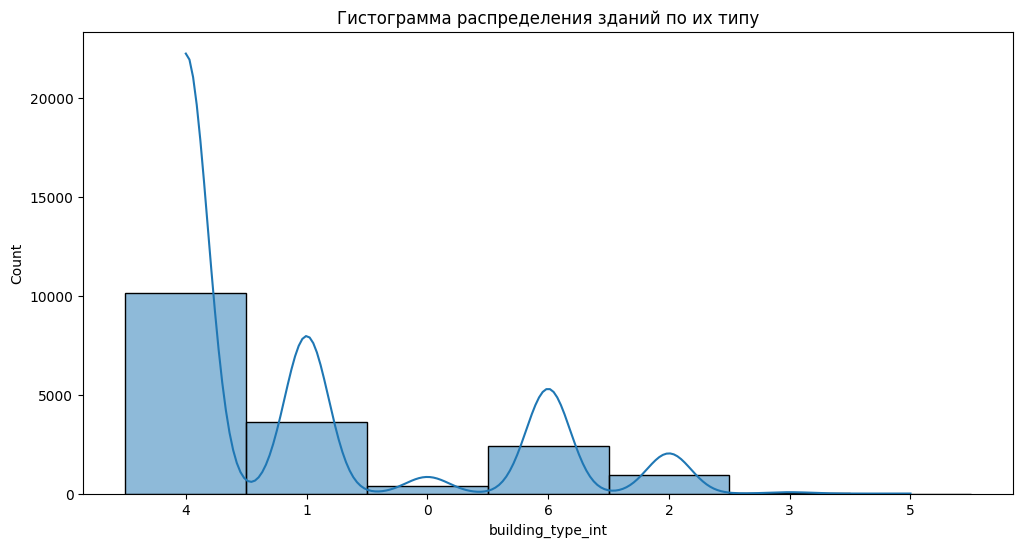

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x="building_type_int", kde=True, ax=ax)
plt.title('Гистограмма распределения зданий по их типу')
plt.show()

# Сохранение картинки в директорию
fig.savefig(os.path.join(ASSETS_DIR, 'building_types.png'))

2024-05-16 11:22:48,165 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-05-16 11:22:48,187 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


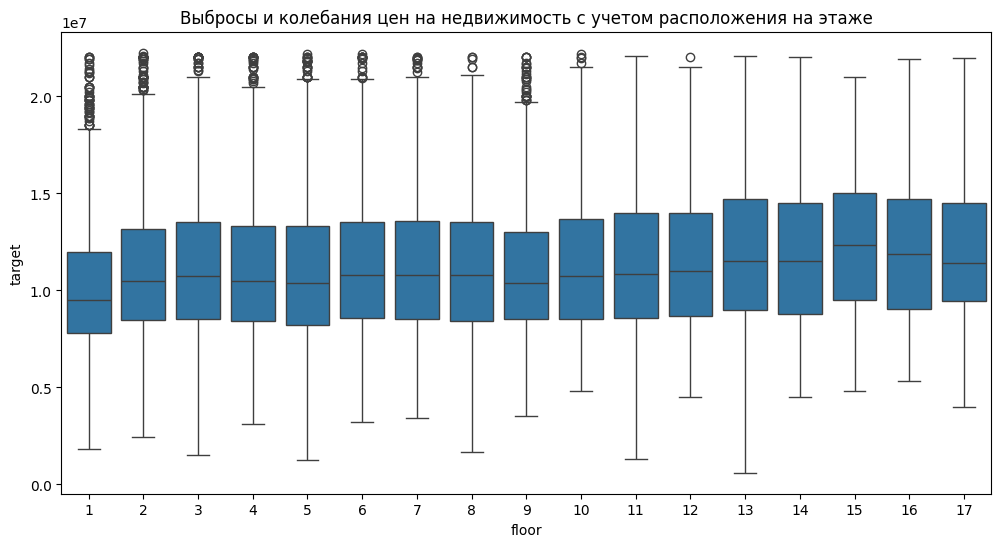

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df, x="floor", y="target", ax=ax)
plt.title('Выбросы и колебания цен на недвижимость с учетом расположения на этаже')
plt.show()

# Сохранение картинки в директорию
fig.savefig(os.path.join(ASSETS_DIR, 'floors_vs_target.png'))

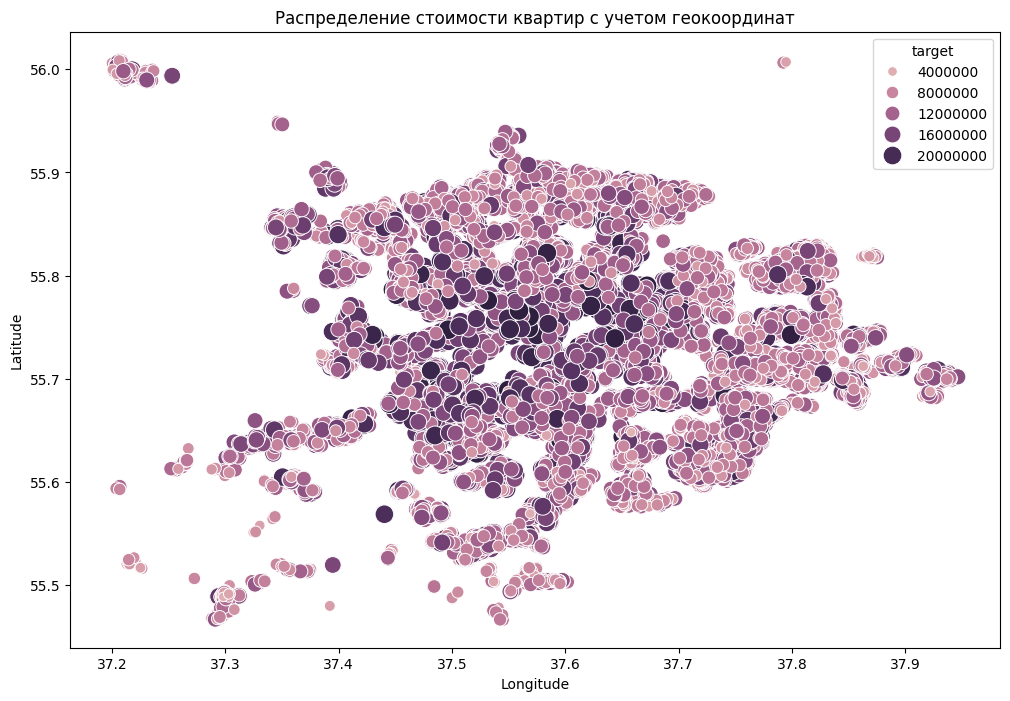

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(data=df, x='longitude', y='latitude', hue='target', size='target', sizes=(20, 200), ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Распределение стоимости квартир с учетом геокоординат')
plt.show()

# Сохранение картинки в директорию
fig.savefig(os.path.join(ASSETS_DIR, 'GEO_vs_target.png'))

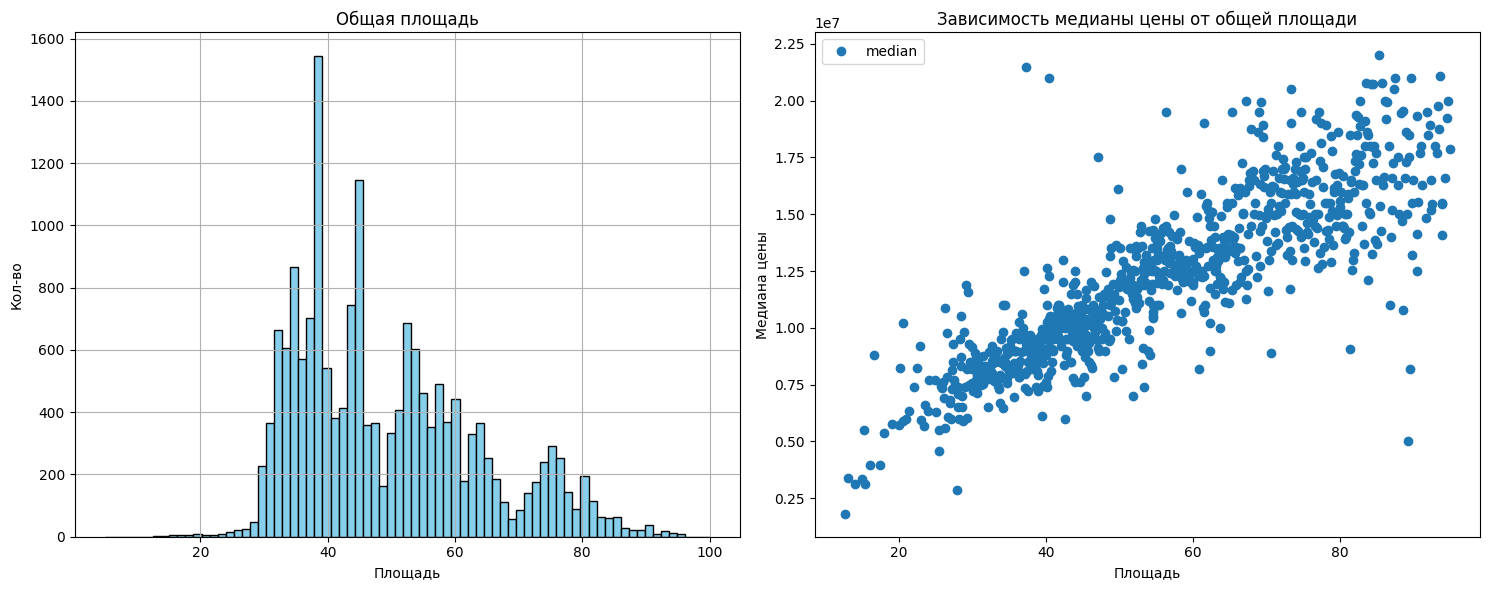

Коэффициент корреляции Пирсона: 0.6400728084749457


In [33]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# График распределения общей площади
axs[0].hist(df['total_area'], bins=75, range=(5, 100), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Площадь')
axs[0].set_ylabel('Кол-во')
axs[0].set_title('Общая площадь')
axs[0].grid(True)

# График зависимости медианы цены от общей площади
pivot_table_total_area = df.pivot_table(index='total_area', values='target', aggfunc=['median']).droplevel(level=1, axis=1)
pivot_table_total_area.sort_values('median', ascending=False).plot(y='median', style='o', ax=axs[1])
axs[1].set_xlabel('Площадь')
axs[1].set_ylabel('Медиана цены')
axs[1].set_title('Зависимость медианы цены от общей площади')

plt.tight_layout()
fig.savefig(os.path.join(ASSETS_DIR, 'total_area_vs_target'))

plt.show()
print('Коэффициент корреляции Пирсона:',df['total_area'].corr(df['target']))

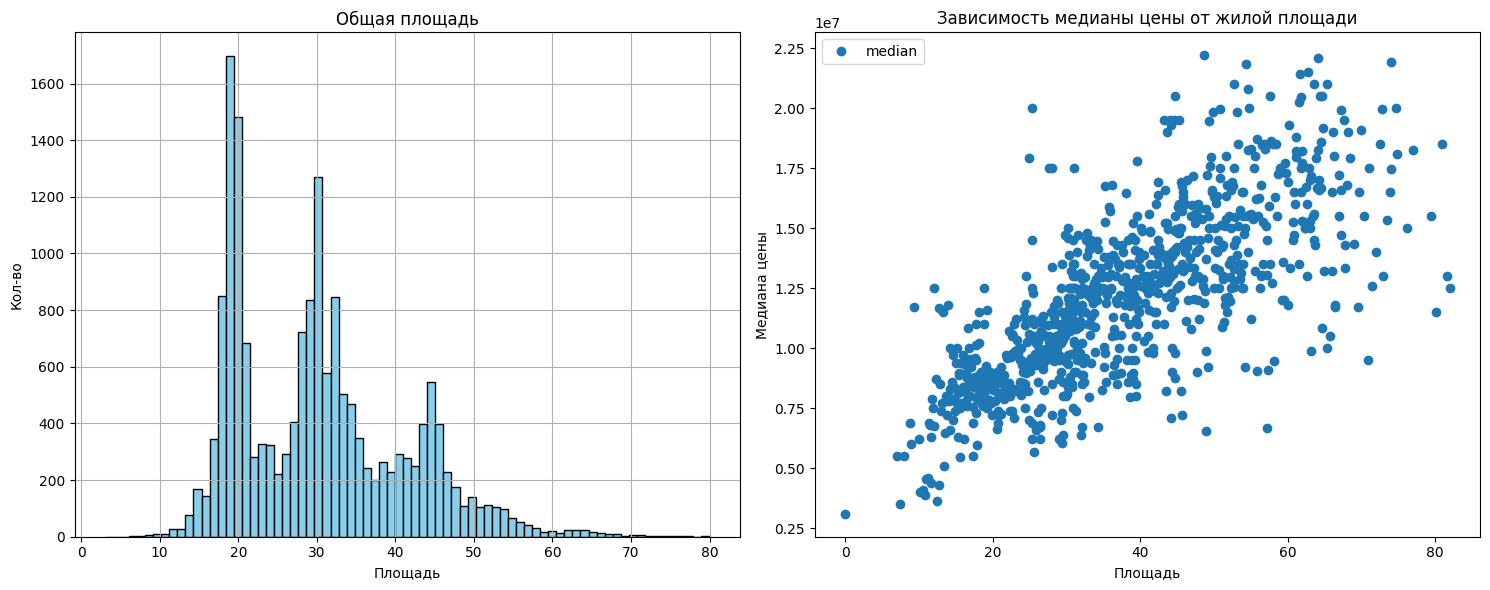

Коэффициент корреляции Пирсона: 0.5821627124037244


In [34]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# График распределения жилой площади
axs[0].hist(df['living_area'], bins=75, range=(3, 80), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Площадь')
axs[0].set_ylabel('Кол-во')
axs[0].set_title('Общая площадь')
axs[0].grid(True)

# График зависимости медианы цены от жилой площади
pivot_table_living_area = df.pivot_table(index='living_area', values='target', aggfunc=['median']).droplevel(level=1, axis=1)
pivot_table_living_area.sort_values('median', ascending=False).plot(y='median', style='o', ax=axs[1])
axs[1].set_xlabel('Площадь')
axs[1].set_ylabel('Медиана цены')
axs[1].set_title('Зависимость медианы цены от жилой площади')

plt.tight_layout()
fig.savefig(os.path.join(ASSETS_DIR, 'living_area_vs_target'))

plt.show()
print('Коэффициент корреляции Пирсона:',df['living_area'].corr(df['target']))

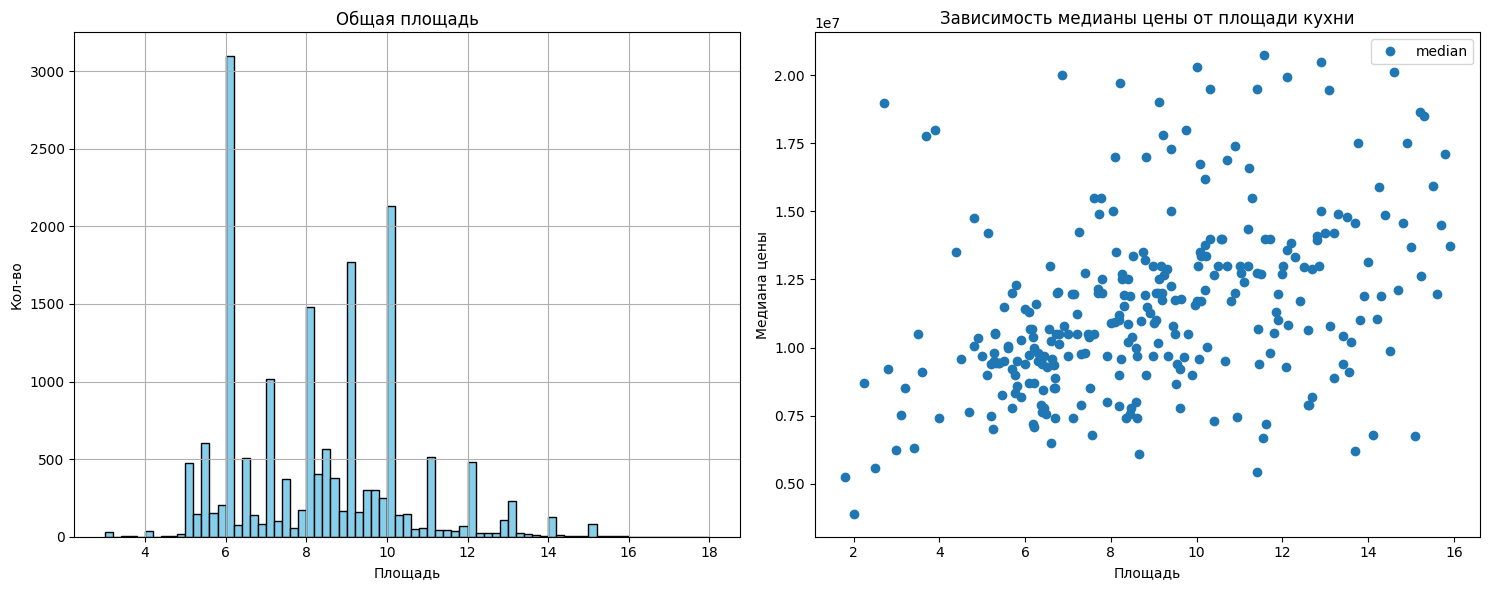

Коэффициент корреляции Пирсона: 0.2982826066599244


In [35]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# График распределения площади кухни
axs[0].hist(df['kitchen_area'], bins=75, range=(3, 18), color='skyblue', edgecolor='black')
axs[0].set_xlabel('Площадь')
axs[0].set_ylabel('Кол-во')
axs[0].set_title('Общая площадь')
axs[0].grid(True)

# График зависимости медианы цены от площади кухни
pivot_table_kitchen_area = df.pivot_table(index='kitchen_area', values='target', aggfunc=['median']).droplevel(level=1, axis=1)
pivot_table_kitchen_area.sort_values('median', ascending=False).plot(y='median', style='o', ax=axs[1])
axs[1].set_xlabel('Площадь')
axs[1].set_ylabel('Медиана цены')
axs[1].set_title('Зависимость медианы цены от площади кухни')

plt.tight_layout()
fig.savefig(os.path.join(ASSETS_DIR, 'kitchen_area_vs_target'))

plt.show()
print('Коэффициент корреляции Пирсона:',df['kitchen_area'].corr(df['target']))

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

По поводу корреляции, чтобы посмотреть взаимоедйствие всех признаков между собой можно построить тепловую карту. См. https://seaborn.pydata.org/generated/seaborn.heatmap.html
    
В качестве коэффициента корреляции можно выбирать не только пирсона, но еще и посмотреть нелинейную корреляцию по https://phik.readthedocs.io/en/latest/

</div>
https://phik.readthedocs.io/en/latest/

Странно что я сразу не постороил тепловую карту, исправился. Спасибо за ссылку на нелинейную корреляцию, займусь изучением.

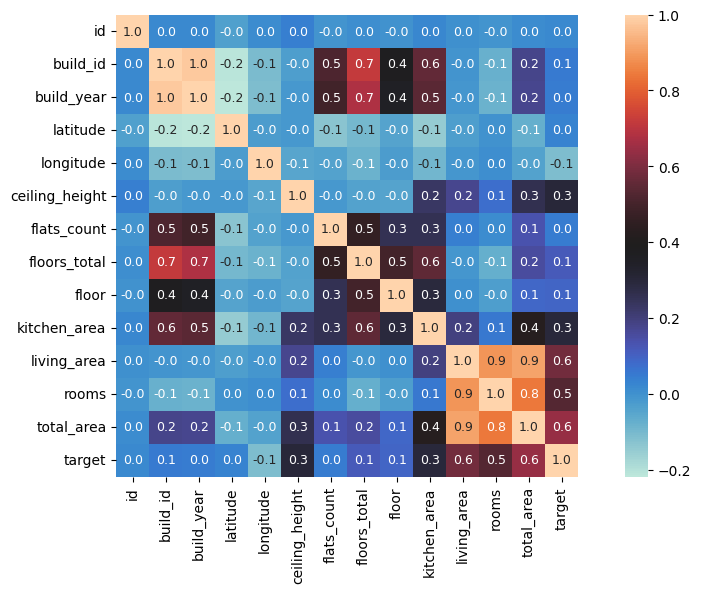

<Figure size 1200x1200 with 0 Axes>

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))
hit_map_features = df.select_dtypes(['float64','int64','datetime'])
plt.figure(figsize=(12, 12))
corr_m = hit_map_features.corr()
sns.heatmap(corr_m, square=True, annot=True, fmt='.1f', cmap='icefire', annot_kws={'size':9},ax=ax)

plt.show()
fig.savefig(os.path.join(ASSETS_DIR, 'hit_map.png'))


count    1.752100e+04
mean     1.122007e+07
std      3.724475e+06
min      6.000000e+05
25%      8.400000e+06
50%      1.050000e+07
75%      1.350000e+07
max      2.224400e+07
Name: target, dtype: float64


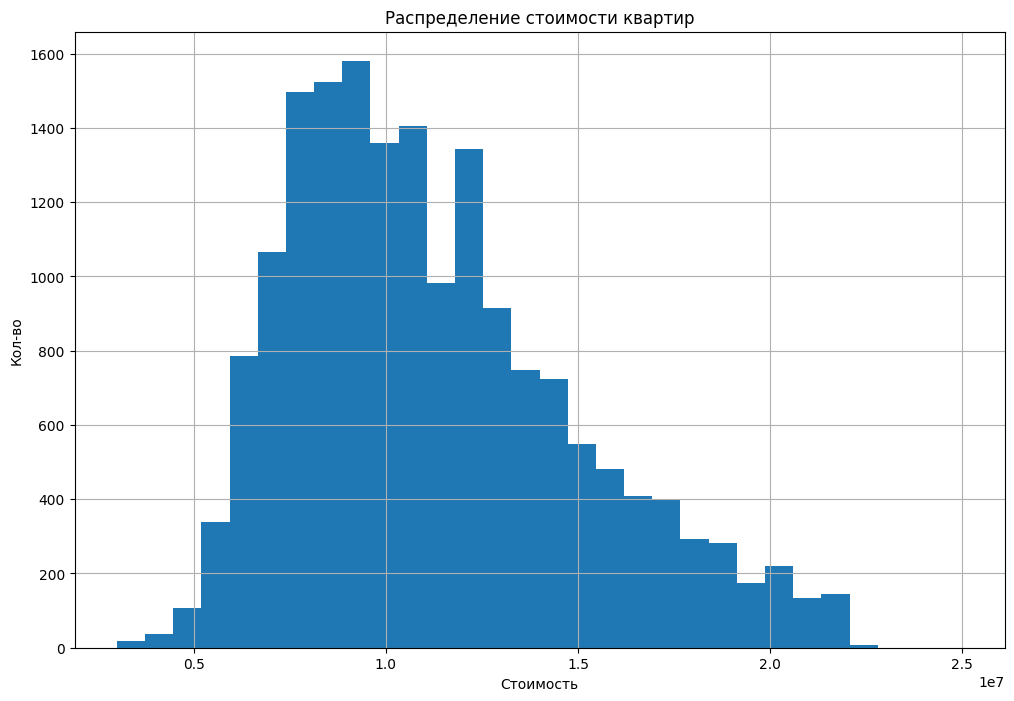

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df['target'].plot(kind='hist', bins=30, range=(3000000,25000000), title='Распределение стоимости квартир', grid=True)
ax.set_xlabel('Стоимость')
ax.set_ylabel('Кол-во')
print(df['target'].describe())
plt.savefig(os.path.join(ASSETS_DIR, 'target_scattering'))

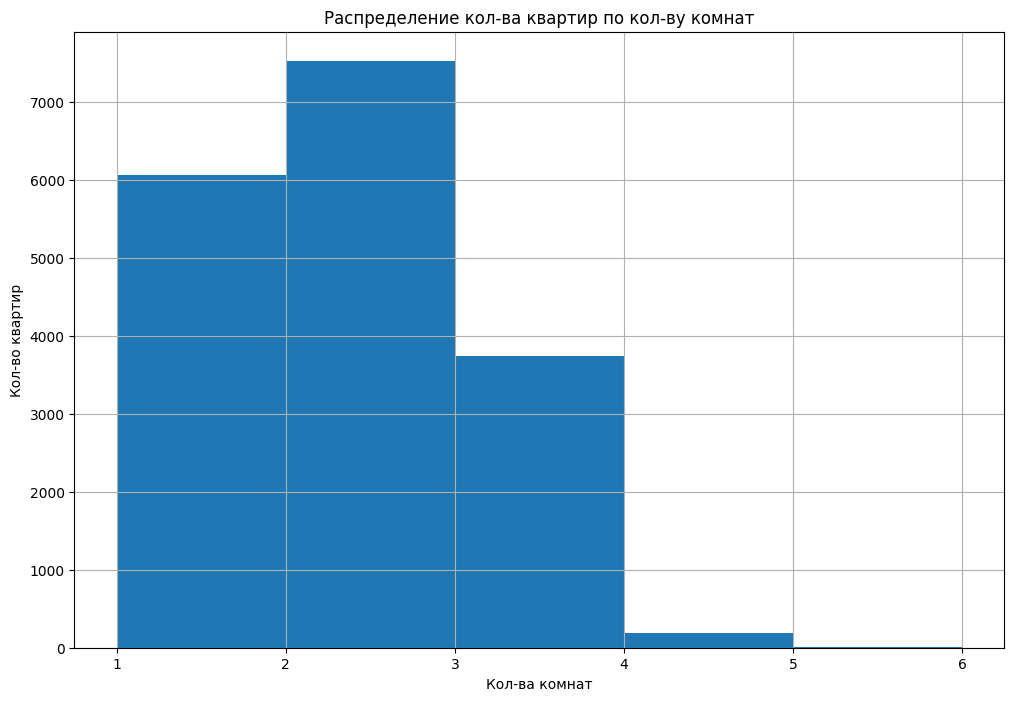

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df['rooms'].plot(kind='hist', bins=5, range=(1,6), title='Распределение кол-ва квартир по кол-ву комнат', grid=True)
ax.set_xlabel('Кол-ва комнат')
ax.set_ylabel('Кол-во квартир')
df['rooms'].describe()
plt.savefig(os.path.join(ASSETS_DIR, 'rooms_scattering'))

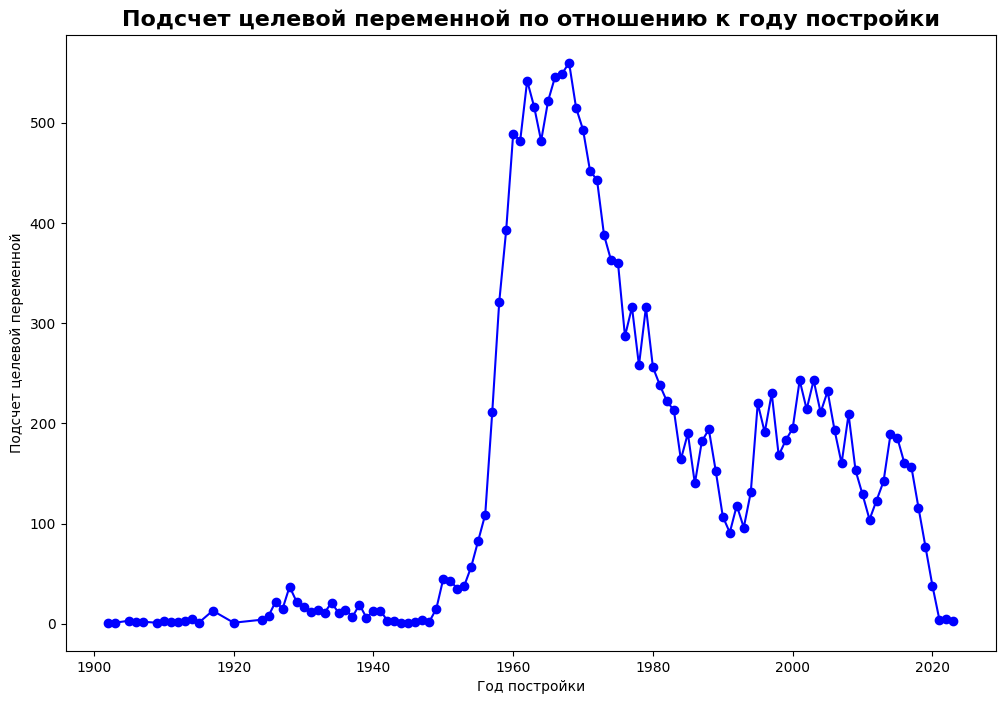

In [44]:
# Создание фигуры для графика
fig, ax = plt.subplots(figsize=(12, 8))

x = "build_year"
target = "target"
stat = ["count"]

target_agg_by_date = df.groupby([x]).agg({target: stat}).reset_index()
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

plt.plot(target_agg_by_date[x], target_agg_by_date["target_count"], marker='o', color='b')

plt.xlabel('Год постройки')
plt.ylabel('Подсчет целевой переменной')
plt.title('Подсчет целевой переменной по отношению к году постройки', fontsize=16, fontweight='bold')

plt.savefig(os.path.join(ASSETS_DIR, 'target_count_by_build_year'))

plt.show()

**ВЫВОД** : 

Данные достаточно чистые, пропущенных значений и дубликатов нет. Неявные дубликаты тоже не встретились. Явных выбросов тоже нет, один из столбцов 'studio' содержал одно лишь значение False. Столбец удален еще на этапе загрузки данных. Столбец living_area содержит  732 нулевых значения. Очевидно это ошибка в заполнении данных. Заполнил это наюлюдение разность между общей площадью и площадью кухни, правда это не точное значение, не учитывающее площадь санузлов и коридоров. Добавил признак "building_age" который указывает на возраст строения, используя текущий год и дату постройки.

Итого, в представленной выборке три очевидных категориальных признака: 'building_type_int', 'has_elevator', 'is_apartment', из них два бинарные, один признак с типом datetime и остальные выглядят как числовые, хотя к-во комнат, этаж, могут вполне быть и категориальными.

Общая площадь в нашей выборке колеблется от 12.65 до 95, среднее значение 49.3,  а медиана 45. 
Цены на недвижимость имеют среднее значение в 11 220 070 млн руб., медиана 10 500 000 млн руб. Распределение данных Гаусса.
Количество комнат колеблется от 1 до 5. Больше всего двухкомнатных квартир.
Высота потолков в среднем составляет 2,7 м, медиана 2,6 м. 

Согласно статистических исследований, прослеживается определенная корреляция целевой переменной с общей площадью, но сильно высокой ее не назвать (коэффициент корреляции Пирсона в пределах 64%), ниже коэффициэнт корреляции с жилой площадью и что поразило, с площадью кухни. Самая распространенная площадь в районе 6 (полагаю м2). Удивлен, но не заметил что этаж сильно влияет на целевую переменную. Больше всего квартир в домах построенных в 60-70. Очевидно что есть некая зависимость от географических координат, но в екущем виде работать с этим непросто.

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

>Неявные дубликаты искать думаю бесперспективно не располагая конкретными id квартир 

Не совсем поняла, что это значит. Во первых у нас есть id квартир - но с id это поиск явных дубликатов. Неявные это без id. Почему бесперспективно?
    
> Столбец living_area содержит не совсем 732 нулевых значения.
И что с этим будешь делать? Совсем ничем не заполнять еще хуже, лучше будут какие то примерные данные, чем нулевые.

>'build_year' привел к значению year, полагаю так проще будет в дальнейшем нормализовать

Что это значит? Что такое значение year? Можно было бы сделать age, возраст дома.
    
    
В остальном выводы верные, графики хорошие, информативные. Молодец!

</div>

Спасибо за совет! Я подкорректировал.

In [61]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели.

In [62]:
EXPERIMENT_NAME = "Futures generation and model training"
RUN_NAME = "Nick_projecr _run_3"

In [63]:
columns_list = df.columns.tolist()
columns_text = ",".join(columns_list) 
with open("columns.txt", "w", encoding="utf-8") as mns:
    mns.write(columns_text)
    
df.to_csv("flat_cleaned_churn", index=False)  

In [65]:
#фичей не так много, определяю их простым образом.
num_columns = ['ceiling_height', 'flats_count', 'floors_total', 'floor', 'kitchen_area',
                    'living_area', 'rooms', 'total_area', 'latitude', 'longitude', 'building_age']
cat_columns = ['building_type_int', 'is_apartment', 'has_elevator']
data_columns = ['build_year']

In [66]:
#создаю словарь параметров.
params = {
    'categories': 'auto',
    'handle_unknown': 'ignore',
    'max_categories': 10,
    'sparse_output': False,
    'drop': 'first',
    'degree': 2,
    'n_bins': 5,
    'encode': 'ordinal',
    'strategy': 'uniform',
    'subsample': None,
}

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Это все конечно лучше хранить в yaml файле в константах, либо хотя бы зафиксировать как константы более явно, в одной ячейке, записав их заглавными буквами.

Вот несколько вариантов использования констант:
1. Константы можно определять заглавными буквами в начале скрипта, после импортов:
import numpy as np
TOKEN_ID = "12345"
2. Или же можно создать отдельный файл с константами, например constants.py, в котором определить эту константу так же, как выше, а затем:
from constants import TOKEN_ID
3. Еще один способ, залить константу в .env, как свои креды и использовать так:
os.environ.get("TOKEN_ID")
Или:
load_dotenv()
os.getenv("TOKEN_ID")
Больше информации можно почитать, например, здесь: https://realpython.com/python-constants/

</div>

Согласен с тобой, этой штуке в yaml самое место! Почему сделал так, дело в том что проще иметь их сейчас перед глазами. За материал еще раз спасибо! Мне немного не хватает программистской практики. 

In [67]:
# 3.1 ручная генерация признаков
encoder_sc =  StandardScaler()
encoder_oh = OneHotEncoder(categories = params['categories'], handle_unknown = params['handle_unknown'],
                           max_categories = params['max_categories'], sparse_output = params['sparse_output'], drop = params['drop'])

encoder_pol = PolynomialFeatures(degree = params['degree'])

encoder_kbd = KBinsDiscretizer(n_bins = params['n_bins'], encode = params['encode'], strategy = params['strategy'], subsample = params['subsample'])

encoder_mm = MinMaxScaler()

numeric_transformer = ColumnTransformer(transformers=[
                                                     ('sk', encoder_sc, num_columns),
                                                     ('pol', encoder_pol, num_columns), 
                                                     ('kbd', encoder_kbd, num_columns)
                                                     ])

data_transformer = ColumnTransformer(transformers=[('dt', encoder_mm, data_columns)])

categorical_transformer = Pipeline(steps=[('encoder', encoder_oh)])

# 3.2 оборачивание всех преобразований в объекты sklearn

preprocessor =  ColumnTransformer(transformers=[('num', numeric_transformer, num_columns),
                                                ('dt', data_transformer, data_columns ),
                                                ('cat', categorical_transformer, cat_columns)], n_jobs=-1)

In [68]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  ColumnTransformer(transformers=[('sk',
                                                                                   StandardScaler(),
                                                                                   ['ceiling_height',
                                                                                    'flats_count',
                                                                                    'floors_total',
                                                                                    'floor',
                                                                                    'kitchen_area',
                                                                                    'living_area',
                                                                                    'rooms',
                                                                                    'total_area',
                                                                                    'latitude',
                                                                                    'longitude',
                                                                                    'building_age']),
                                                                                  ('pol',
                                                                                   PolynomialFeatures(),
                                                                                   ['ceiling_height',
                                                                                    'flats_count',
                                                                                    'floors_t...
                                                   'living_area', 'rooms',
                                                   'total_area', 'latitude',
                                                   'longitude',
                                                   'building_age']),
                                                 ('dt',
                                                  ColumnTransformer(transformers=[('dt',
                                                                                   MinMaxScaler(),
                                                                                   ['build_year'])]),
                                                  ['build_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=10,
                                                                                 sparse_output=False))]),
                                                  ['building_type_int',
                                                   'is_apartment',
                                                   'has_elevator'])]))])

In [69]:
# 3.3 автоматическая генерация признаков
#Обновляю список признаков. В AutoFeatRegressor добавлю исключительно цифровые признаки
num_columns = ['ceiling_height', 'flats_count', 'floors_total', 'floor','rooms','latitude', 'longitude']
data_columns = ['build_year']
afr_columns = ['kitchen_area','living_area','total_area','building_age']
cat_columns = ['building_type_int', 'is_apartment','has_elevator']

In [70]:
# Обновлю список параметров
params['feateng_steps'] = 2 # применю умеренное количество шагов
params['featsel_runs'] = 3 # три подхода к выбору признаков
params['max_gb'] = None # предоставлю всю доступную память
params['n_jobs'] = -1 # количество параллельных задач
params['transformations'] = ('1/', 'log', 'abs', 'sqrt') 
params['units'] = None # не фиксирую единицу измерения
params['verbose'] = 0 # отключаю вывод информации

In [71]:
encoder_oh = OneHotEncoder(categories = params['categories'], handle_unknown = params['handle_unknown'],
                           max_categories = params['max_categories'], sparse_output = params['sparse_output'], drop = params['drop'])

encoder_pol = PolynomialFeatures(degree = params['degree'])

encoder_mm = MinMaxScaler()

encoder_kbd = KBinsDiscretizer(n_bins = params['n_bins'], encode = params['encode'], strategy = params['strategy'], subsample = params['subsample'])

encoder_afr = AutoFeatRegressor(feateng_steps = params['feateng_steps'], featsel_runs = params['featsel_runs'], 
                                max_gb = params['max_gb'], n_jobs = params['n_jobs'], transformations = params['transformations'],
                                units = params['units'], verbose = params['verbose'])
scaler = StandardScaler()

In [72]:
#Выборка не сказать что большая, применю простое разделение
X = df.drop('target', axis=1).copy()
y = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# 3.4 обучение новой версии модели
model = LinearRegression(fit_intercept=True)  
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('scaler', scaler),
        ('model', model)
    ]
    )

In [74]:
# 3.4 обучение новой версии модели
start_time = time.time() 
pipeline.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print("Время обучения:", training_time, "секунд")

Время обучения: 1.7170755863189697 секунд


<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Подсчет метрик можно загнать в функцию evaluate и можно будет красиво  и лаконично вызывать один метод для фиксирования метрик)

Метрики здесь ты вывел, но в первом этапе не вывел. Кроме того было бы удобно их сравнивать на графике. Предлагаю построить график динамики метрик на каждом этапе после того как получишь новую модель. 

    
Ну и какие то выводы хотелось бы увидеть, стало лучше или хуже. И если хуже то как думаешь почему и что можно было бы сделать в теории

</div>

Согласен, это действительно правильные действия. Исправляюсь.

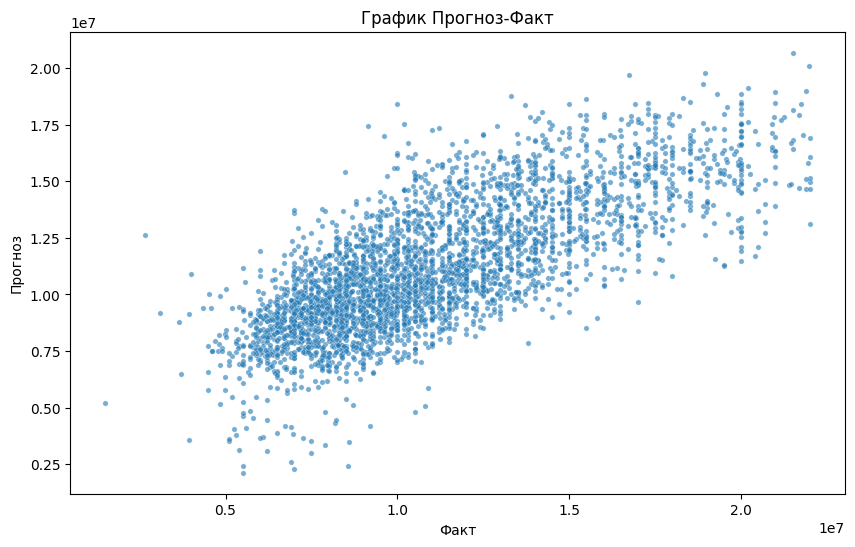

In [75]:
plot_prediction_fact (X_test, y_test, pipeline)

In [76]:
evaluation_results_autogeneration = evaluate(pipeline, X_test, y_test)
evaluation_results_autogeneration

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки': 1941003.71,
 'Средняя квадратичная ошибка': 5858603080457.65,
 'Коэффициент детерминации': 0.57,
 'Средняя абсолютная ошибка в процентах': 0.19,
 'Время предсказания в секундах': 0.052492618560791016}

In [77]:
#Оберну графики сравнения метрик в функцию, поскольку вызывать ее буду неоднократно.
def plot_error_comparison(evaluation_results_1, evaluation_results_2):
    mse_value_1 = evaluation_results_1.get('Средняя квадратичная ошибка', 0)
    mse_value_2 = evaluation_results_2.get('Средняя квадратичная ошибка', 0)
    
    mape_value_1 = evaluation_results_1.get('Средняя абсолютная ошибка в процентах', 0)
    mape_value_2 = evaluation_results_2.get('Средняя абсолютная ошибка в процентах', 0)

    mae_value_1 = evaluation_results_1.get('Средний модуль ошибки', 0)
    mae_value_2 = evaluation_results_2.get('Средний модуль ошибки', 0)

    r2_value_1 = evaluation_results_1.get('Коэффициент детерминации', 0)
    r2_value_2 = evaluation_results_2.get('Коэффициент детерминации', 0)

    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    plt.bar([0, 1], [mse_value_1, mse_value_2], color=['b', 'r'])
    plt.xlabel('Модель')
    plt.xticks([0, 1], ['Предыдущая модель', 'Текущая модель'])
    plt.ylabel('Средняя квадратичная ошибка')
    plt.title('Сравнение средней квадратичной ошибки')

    plt.subplot(2, 2, 2)
    plt.bar([0, 1], [mape_value_1, mape_value_2], color=['b', 'r'])
    plt.xlabel('Models')
    plt.xticks([0, 1], ['Предыдущая модель', 'Текущая модель'])
    plt.ylabel('Средняя абсолютная ошибка в процентах')
    plt.title('Сравнение средней абсолютной ошибки в процентах')

    plt.subplot(2, 2, 3)
    plt.bar([0, 1], [mae_value_1, mae_value_2], color=['g', 'purple'])
    plt.xlabel('Models')
    plt.xticks([0, 1], ['Предыдущая модель', 'Текущая модель'])
    plt.ylabel('Средний модуль ошибки')
    plt.title('Сравнение среднего модуля ошибки')

    plt.subplot(2, 2, 4)
    plt.bar([0, 1], [r2_value_1, r2_value_2], color=['y', 'm'])
    plt.xlabel('Models')
    plt.xticks([0, 1], ['Предыдущая модель', 'Текущая модель'])
    plt.ylabel('Коэффициент детерминации')
    plt.title('Сравнение коэффициента детерминации')

    plt.tight_layout()
    plt.show()

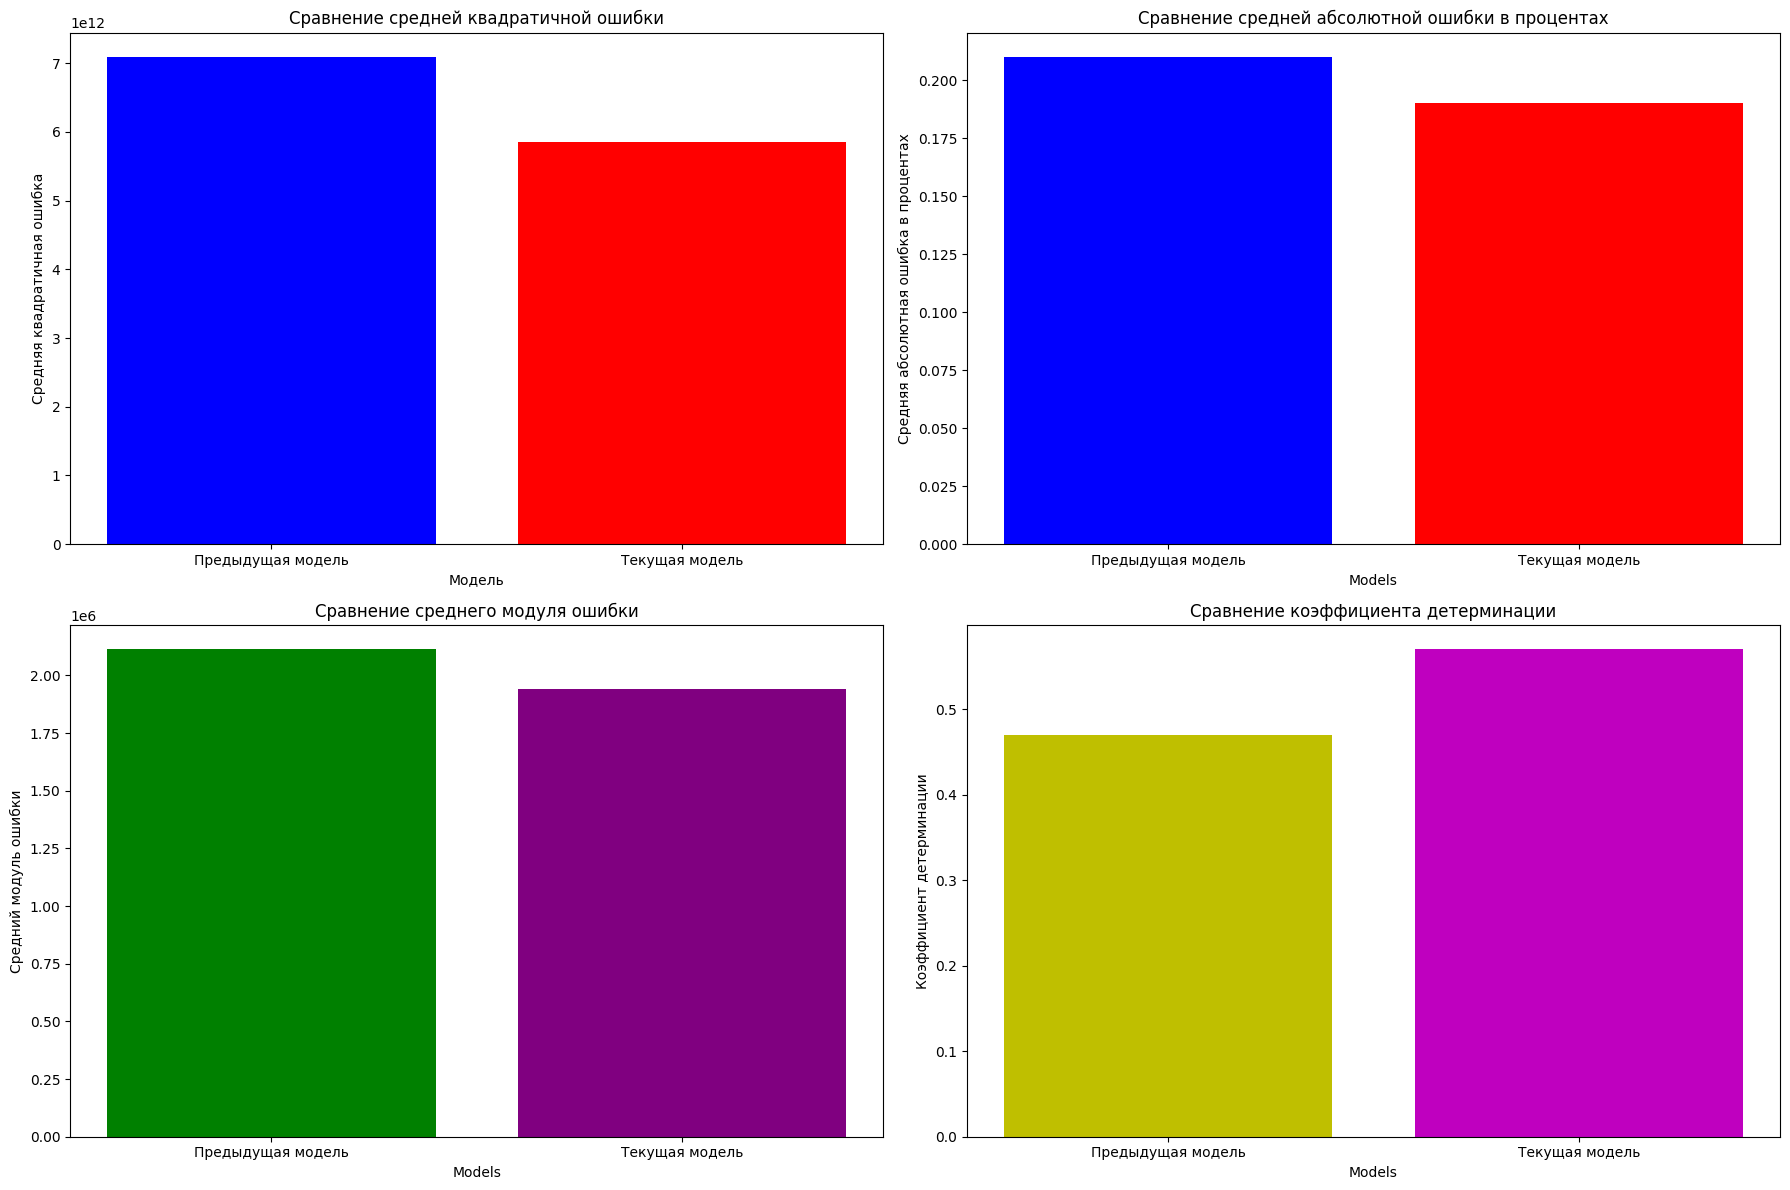

In [78]:
plot_error_comparison(evaluation_results_baseline, evaluation_results_autogeneration)

В целом Модель выглядит не очень идеальной, график дисперсии показывает что разброс довольно велик,но удовлетворительной. Модель после автогенерации признаков имеет лучшие показатели, коэффициент детерминации у новой модели имеет значение 0.57, модель объясняет 57% дисперсии целевой переменной, что приблежает ее к удовлетворительному качеству.

In [79]:
# 3.5 логирование артефактов в MLflow
REGISTRY_MODEL_NAME = "auto_future_gen_model_nikolaimelnikov"

pip_requirements = '../requirements.txt' # ваш код здесь
signature = mlflow.models.infer_signature(X_test, prediction)# ваш код здесь
input_example = input_example = X_test[:10]# ваш код здесь
metadata = {'model_type': 'monthly'}# ваш код здесь

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

model_path = "mlflow_baseline_model"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.sklearn.log_model(pipeline, model_path, pip_requirements=pip_requirements,
                             input_example=input_example, metadata=metadata, signature=signature,
                             registered_model_name=REGISTRY_MODEL_NAME, await_registration_for=6)

    # Дополнительные логгирования метрик и артефактов
    mlflow.log_metrics(evaluation_results_autogeneration)
    mlflow.log_dict(params, "model_params.json") 
    mlflow.log_artifact("columns.txt", artifact_path="dataframe")
    mlflow.log_artifact("flat_cleaned_churn", artifact_path="dataframe")

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Registered model 'auto_future_gen_model_nikolaimelnikov' already exists. Creating a new version of this model.

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели

In [80]:
EXPERIMENT_NAME = "Future selection"
RUN_NAME = "Nick_projecr _run_4"
REGISTRY_MODEL_NAME = 'model_with_selected_futures'
FS_ASSETS = "fs_assets" 
os.mkdir(FS_ASSETS)

In [81]:
num_columns = ['ceiling_height', 'flats_count', 'floors_total', 'floor','rooms']
data_columns = ['build_year']
afr_columns = ['kitchen_area','living_area','total_area', 'latitude', 'longitude','building_age']
cat_columns = ['building_type_int', 'is_apartment','has_elevator']

In [82]:
#Немного поправлю параметры
params = {
    'categories': 'auto',
    'handle_unknown': 'ignore',
    'max_categories': 10,
    'sparse_output': False,
    'drop': 'first',
    'degree': 2,
    'n_bins': 6, # увеличу количество корзин
    'encode': 'ordinal',
    'strategy': 'uniform',
    'subsample': None,
}
params['feateng_steps'] = 4
params['featsel_runs'] = 5 #чуть больше подходов к выбору признаков
params['max_gb'] = None # предоставлю всю доступную память
params['n_jobs'] = -1 # количество параллельных задач
params['transformations'] = ('1/', 'log', 'abs', 'sqrt') 
params['units'] = None # не фиксирую единицу измерения
params['verbose'] = 0 # отключаю вывод информации

In [83]:
# убрал из preprosessor PolynomialFeatures, в виду того что он сильно пересекается по генерации с SFS и генерит такое безумное количество фичей что никакая ВМ не выдерживает.
# KBinsDiscretizer хотя и применен условно к цифровым признакам, тем не менее позволит перевести их в разряд категириальных в виду их неоднозначности.

numeric_transformer = ColumnTransformer(transformers=[('kbd', encoder_kbd, num_columns)])

afr_transformer = ColumnTransformer(transformers=[('afr', encoder_afr, afr_columns)])

data_transformer = ColumnTransformer(transformers=[('dt', encoder_mm, data_columns)])

categorical_transformer = Pipeline(steps=[('encoder', encoder_oh)])

preprocessor =  ColumnTransformer(transformers=[('num', numeric_transformer, num_columns),
                                                ('dt', data_transformer, data_columns ),
                                                 ('afr', afr_transformer, afr_columns),
                                                ('cat', categorical_transformer, cat_columns)], n_jobs=-1)

In [84]:
preprocessor.fit_transform(X_train, y_train)

array([[1., 3., 3., ..., 0., 0., 1.],
       [1., 2., 2., ..., 0., 0., 1.],
       [1., 4., 3., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 3., 2., ..., 0., 0., 1.],
       [3., 3., 4., ..., 0., 0., 1.]])

In [85]:
X_train_processed = preprocessor.transform(X_train)
X_train_processed.shape

(14016, 35)

In [86]:
scaler = StandardScaler()
model = LinearRegression(fit_intercept=True)  
pipe = Pipeline(
    [
        ('scaler', scaler),
        ('model', model)
    ]
    )

In [90]:
# 4.1 Отбор признаков при помощи метода номер 1
sfs =  SFS(estimator = pipe, k_features=6, forward=True, floating=False, scoring= 'neg_mean_squared_error', cv=5, n_jobs=-1)
sfs.fit(X_train_processed, y_train)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('model',
                                                     LinearRegression())]),
                          k_features=(6, 6), n_jobs=-1,
                          scoring='neg_mean_squared_error')

In [91]:
# 4.2 Отбор признаков при помощи метода номер 2
sbs =  SFS(estimator = pipe, k_features=6, forward=False, floating=False, scoring= 'neg_mean_squared_error', cv=5, n_jobs=-1)
sbs.fit(X_train_processed, y_train)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('model',
                                                     LinearRegression())]),
                          forward=False, k_features=(6, 6), n_jobs=-1,
                          scoring='neg_mean_squared_error')

In [92]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели
print('\nSequential Forward Selection (k=6)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)


Sequential Forward Selection (k=6)
CV Score:
-7688615307026.292

Sequential Backward Selection
CV Score:
-7668495535277.248


In [93]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 
sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

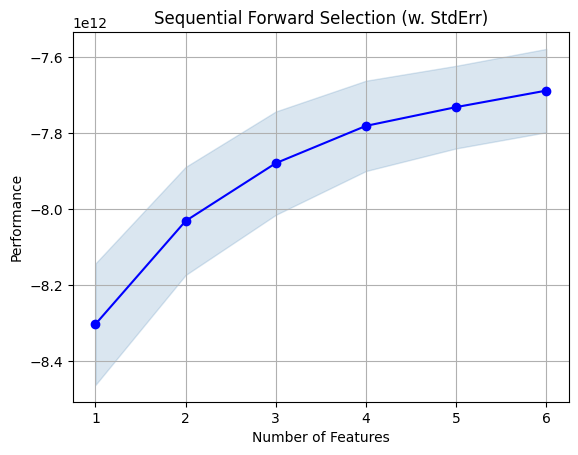

In [96]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()

plt.savefig("/home/mle-user/mle_projects/mle-project-sprint-2-v001/model_improvement/fs_assets/sfs.png")

plt.show()

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Не вижу что тут метрика стабилизируется на 15, у тебя всего 15 признаков? Если да, то ок. А если больше, то график надо бы вывести по всем фичам и увидеть что действительно после 15 роста нет.

</div>

Хм..., на этом графике сложно увидеть, он как раз вернет то количество фичей которое указывали при отборе, а вот Backward по идее может показать. Но я вернул к 6 лучшим фичам.

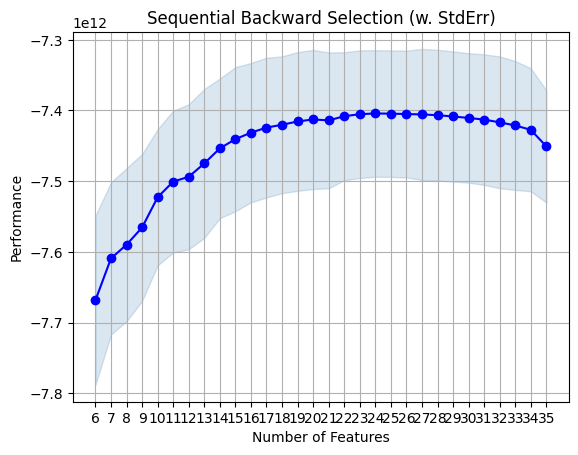

In [97]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()

plt.savefig("/home/mle-user/mle_projects/mle-project-sprint-2-v001/model_improvement/fs_assets/sbs.png")

plt.show()

Согласен, о 15 речи не идет, в этой конфигурации метрика достигает пика при 24 фичах.

In [ ]:
# 4.4 Обучение новой версии модели

In [100]:
top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_
#создам объедененные и пересекающийся набор признаков
interc_features = list(set(top_sbs) & set(top_sfs)) 
union_features = list(set(top_sbs) | set(top_sfs)) 

#проверю какой набор подойдет лучше
def train_and_evaluate_model(features, target):
    scaler = StandardScaler()
    model = LinearRegression(fit_intercept=True)  
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    
    # Обучение модели
    pipe.fit(features, target)
    
    # Предсказание на обучающих данных
    predictions = pipe.predict(features)
    
    # Оценка качества модели с помощью MSE
    mse = mean_squared_error(target, predictions)
    
    return pipe, predictions, mse

In [101]:
# Обучение модели на пересекающихся признаках
model_interc, predictions_interc, mse_interc = train_and_evaluate_model(X_train_processed[:, np.array(interc_features, dtype=int)], y_train)
# Обучение модели на объединяющихся признаках
model_union, predictions_union, mse_union = train_and_evaluate_model(X_train_processed[:, np.array(union_features, dtype=int)], y_train)
# Вывод метрик для сравнения
print("Средняя квадратичная ошибка для пересекающихся признаков:", mse_interc)
print("Средняя квадратичная ошибка для объедененных признаков:", mse_union)

Средняя квадратичная ошибка для пересекающихся признаков: 7873678474094.495
Средняя квадратичная ошибка для объедененных признаков: 7516604085823.231


Дальше пойду с объедененными признаками, и метрики по два раза выводить не буду)))

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Также хочу увидеть динамическое изменение метрик на графике

</div>

Выполняю.

In [103]:
X_test_processed = preprocessor.transform(X_test)

In [104]:
start_time = time.time()
prediction = model_union.predict(X_test_processed[:, np.array(union_features, dtype=int)])
print(prediction)
end_time = time.time()
prediction_time = end_time - start_time
print("Время предсказания:", prediction_time, "секунд")

[ 8930624.36454887 11049883.22764921 11425834.84161119 ...
  9595683.92852639  8977200.46959862 13354371.45547126]
Время предсказания: 0.0019769668579101562 секунд


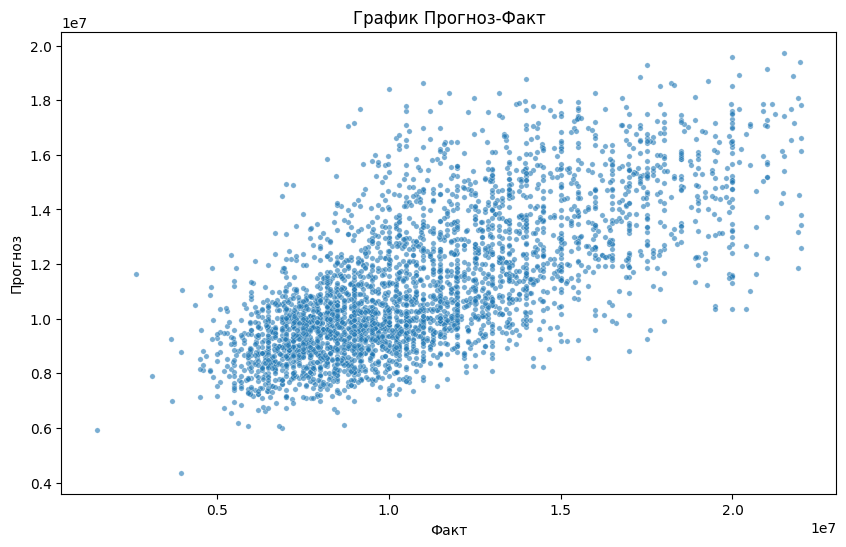

In [108]:
plot_prediction_fact (X_test_processed[:, np.array(union_features, dtype=int)], y_test, model_union)

In [105]:
evaluation_results_future_selection = evaluate(model_union, X_test_processed[:, np.array(union_features, dtype=int)], y_test)
evaluation_results_future_selection

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки': 2115935.8,
 'Средняя квадратичная ошибка': 7096293870351.13,
 'Коэффициент детерминации': 0.47,
 'Средняя абсолютная ошибка в процентах': 0.21,
 'Время предсказания в секундах': 0.0014071464538574219}

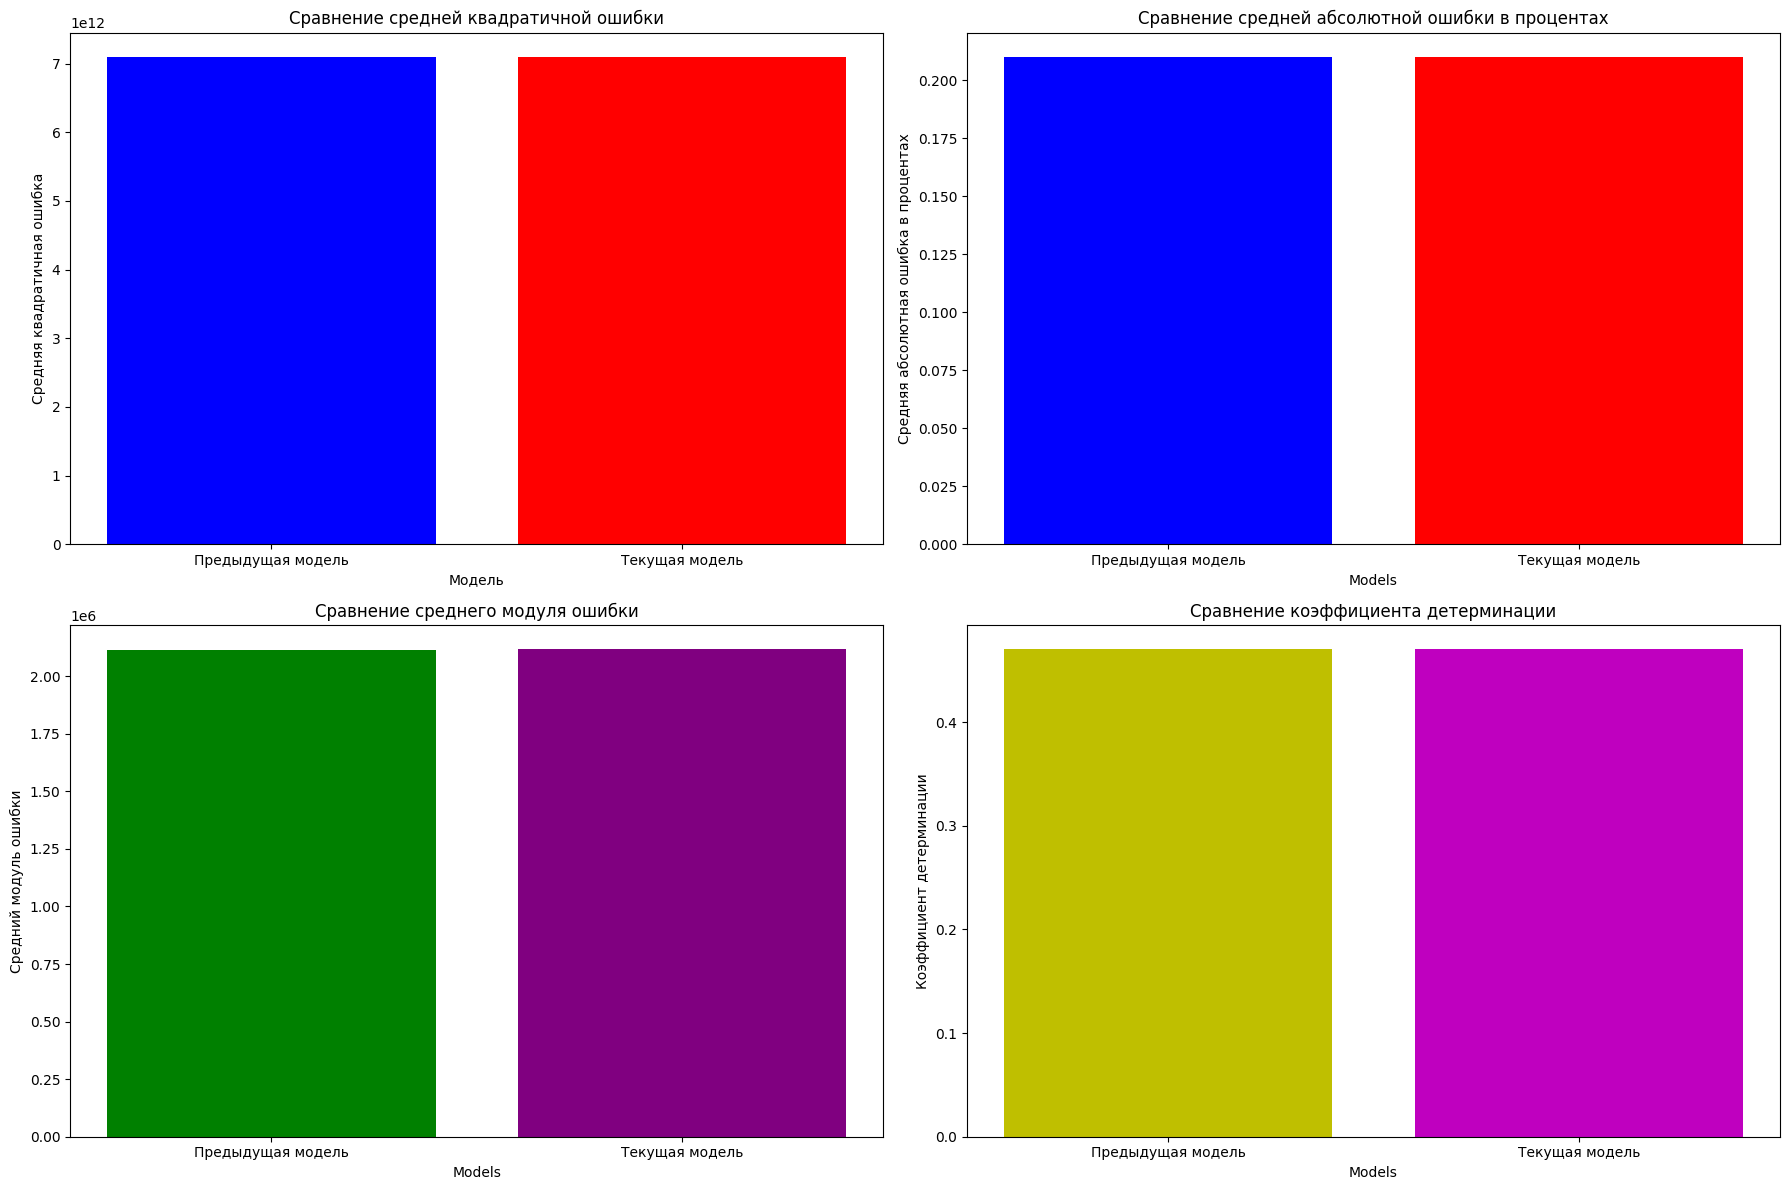

In [106]:
#сравню метрики с базовой моделью
plot_error_comparison(evaluation_results_baseline, evaluation_results_future_selection)

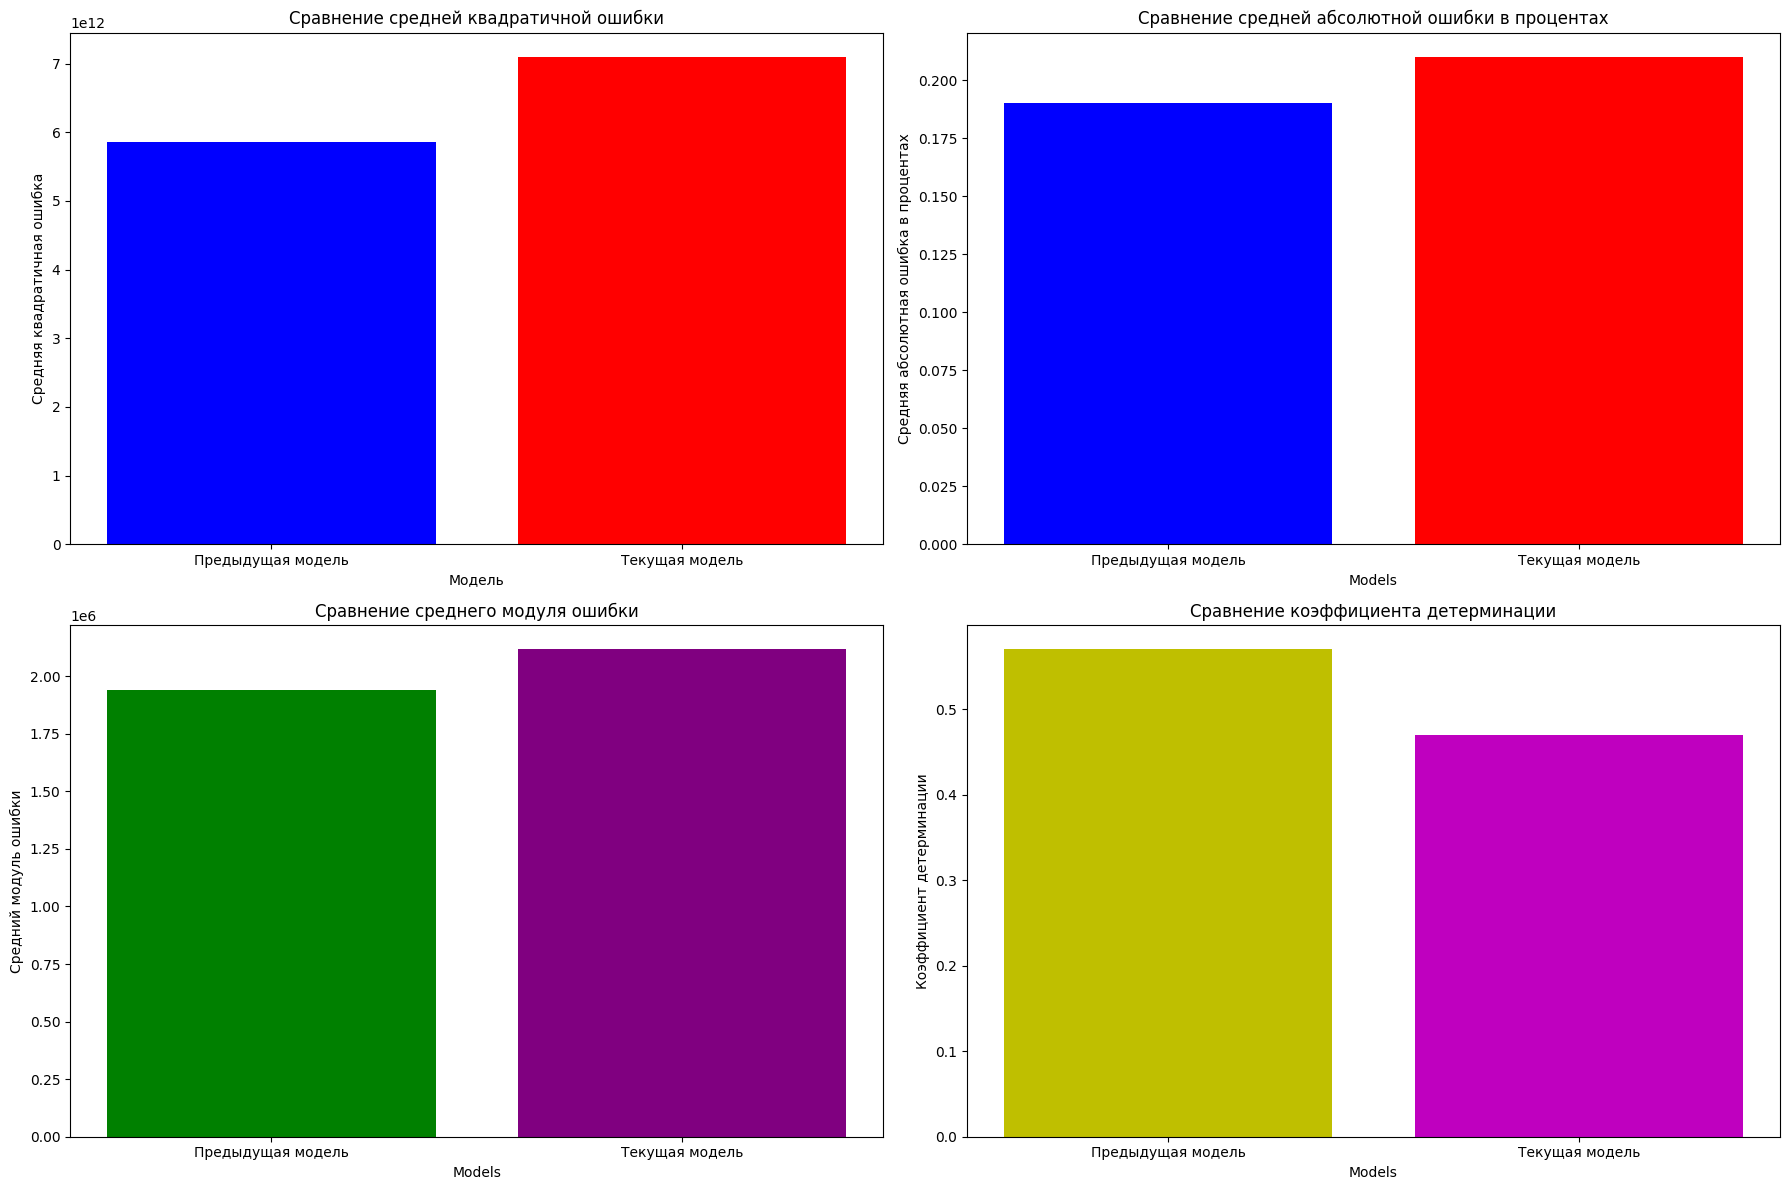

In [107]:
#Сравню метрики с моделью с нагенерированными признаками
plot_error_comparison(evaluation_results_autogeneration, evaluation_results_future_selection)

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

А зачем еще раз ?

</div>

Все лишнее убрал, никаких повторов богомерзских! 

К сожалению Модель полностью вернулась к показателям базовой модели, все метрики незначительно, но хуже предыдущей модели. 

In [109]:
# 4.5 Логирование всех артефактов в MLflow

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    
pip_requirements = '../requirements.txt' # ваш код здесь
input_example = input_example = X_test[:10]# ваш код здесь
metadata = {'model_type': 'monthly'}# ваш код здесь

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.sklearn.log_model(model_union,  artifact_path="models", pip_requirements=pip_requirements,
                             input_example=input_example, metadata=metadata,
                             registered_model_name=REGISTRY_MODEL_NAME, await_registration_for=6)
    # Дополнительные логгирования метрик и артефактов
    mlflow.log_metrics(evaluation_results_future_selection)
    mlflow.log_dict(params, "model_params.json") 
    mlflow.log_artifact("columns.txt", artifact_path="dataframe")
    mlflow.log_artifact("flat_cleaned_churn", artifact_path="dataframe")
    mlflow.log_artifacts(FS_ASSETS)


/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/mlflow/models/signature.py:333: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  input_schema = _infer_schema(input_ex)
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/sklearn/base.py:458: UserWarn

### Этап 5 - подбор гиперпараметров и обучение новой версии модели


In [110]:
EXPERIMENT_NAME = "Best hyper parametres selection"
RUN_NAME = "Nick_projecr _run_5"
REGISTRY_MODEL_NAME = 'optuna_selected_model'

In [131]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1
# Определение параметров для GridSearchCV
parameters = {
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False],
    'model__n_jobs': [-1, 1, 2, 4],
    'model__positive': [True, False],
}
def train_and_evaluate_model(features, target):
    scaler = StandardScaler()
    model = LinearRegression()  
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    
    # Определение GridSearchCV
    grid_search = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Обучение модели с поиском по сетке
    grid_search.fit(features, target)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    
    # Получение предсказаний на обучающих данных с лучшей моделью
    prediction = grid_search.predict(features)
    
    # Оценка качества модели с помощью MSE
    mse = mean_squared_error(target, prediction)
    
    return grid_search, prediction, mse, best_params


In [132]:
# Обучение модели на интерцептирующихся признаках с поиском по сетке
start_time = time.time() 
best_model_grid, predictions_interc, mse, best_params = train_and_evaluate_model(X_train_processed[:, np.array(union_features, dtype=int)], y_train)

# Вывод метрик для сравнения

print("Средняя квадратичная ошибка:", mse_union)
print("Время обучения:", training_time, "секунд")
print("Лучшие подобранные параметры:", best_params)

Средняя квадратичная ошибка: 7516604085823.231
Время обучения: 2267.5929622650146 секунд
Лучшие подобранные параметры: {'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': -1, 'model__positive': False}


In [133]:
best_model_grid

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__n_jobs': [-1, 1, 2, 4],
                         'model__positive': [True, False]},
             scoring='neg_mean_squared_error')

In [134]:
start_time = time.time()
prediction = best_model_grid.predict(X_test_processed[:, np.array(union_features, dtype=int)])
print(prediction)
end_time = time.time()
prediction_time = end_time - start_time
print("Время предсказания:", prediction_time, "секунд")

[ 8930624.36454887 11049883.22764921 11425834.84161119 ...
  9595683.92852639  8977200.46959862 13354371.45547126]
Время предсказания: 0.0038068294525146484 секунд


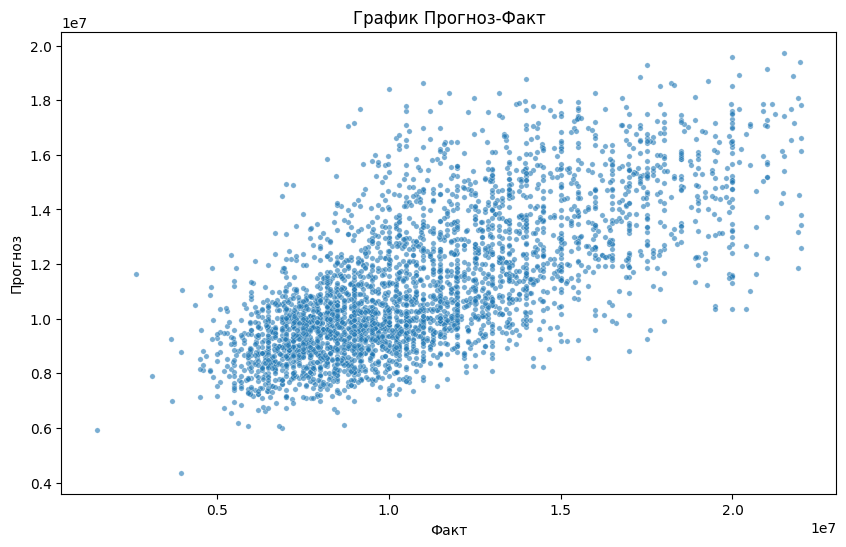

In [135]:
plot_prediction_fact (X_test_processed[:, np.array(union_features, dtype=int)], y_test, best_model_grid)

In [137]:
evaluation_results_grid_selection = evaluate(model_union, X_test_processed[:, np.array(union_features, dtype=int)], y_test)
evaluation_results_grid_selection

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки': 2115935.8,
 'Средняя квадратичная ошибка': 7096293870351.13,
 'Коэффициент детерминации': 0.47,
 'Средняя абсолютная ошибка в процентах': 0.21,
 'Время предсказания в секундах': 0.007565975189208984}

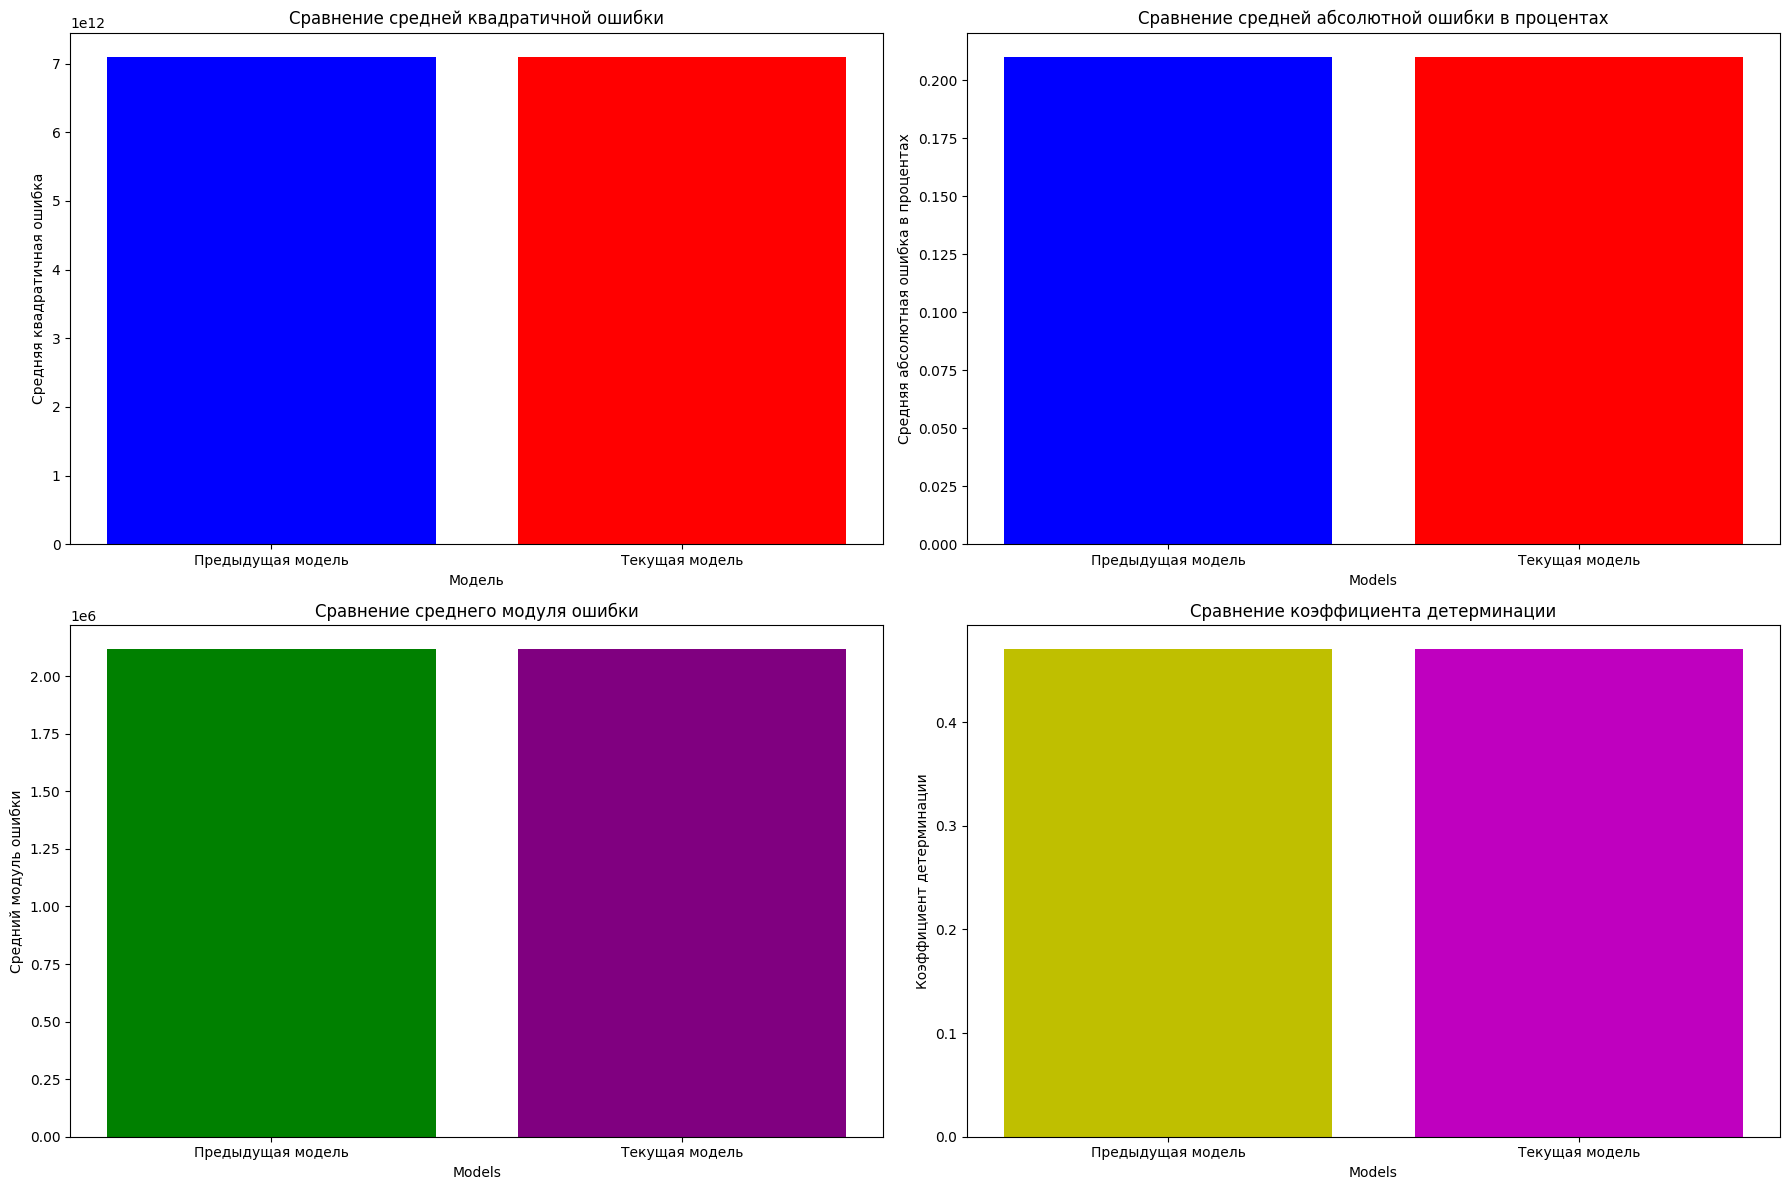

In [138]:
plot_error_comparison(evaluation_results_future_selection, evaluation_results_grid_selection)

Опять метрики остались на уровне предыдущей модели.

In [139]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2
def objective(trial):
    # Определение гиперпараметров
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    copy_X = trial.suggest_categorical('copy_X', [True, False])
    n_jobs = trial.suggest_categorical('n_jobs', [-1, 1, 2, 4])
    positive = trial.suggest_categorical('positive', [True, False])

    scaler = StandardScaler()
    model = LinearRegression(fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs, positive=positive)
    pipe = Pipeline([('scaler', scaler), ('model', model)])

    # Оценка модели через кросс-валидацию с использованием MSE 
    mse_scores = -cross_val_score(pipe, X_train_processed, y_train, cv=5, scoring='neg_mean_squared_error')
    
    return np.mean(mse_scores)

sampler = TPESampler(seed=10)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=100)

best_fit_intercept = study.best_params['fit_intercept']
best_copy_X = study.best_params['copy_X']
best_n_jobs = study.best_params['n_jobs']
best_positive = study.best_params['positive']

print("Best fit_intercept:", best_fit_intercept)
print("Best copy_X:", best_copy_X)
print("Best n_jobs:", best_n_jobs)
print("Best positive:", best_positive)

[I 2024-05-16 13:53:37,291] A new study created in memory with name: no-name-faba2082-5225-4198-b54c-f2655b85ca12
[I 2024-05-16 13:53:37,488] Trial 0 finished with value: 7688349702625.467 and parameters: {'fit_intercept': True, 'copy_X': False, 'n_jobs': 4, 'positive': True}. Best is trial 0 with value: 7688349702625.467.
[I 2024-05-16 13:53:37,679] Trial 1 finished with value: 134347013564262.3 and parameters: {'fit_intercept': False, 'copy_X': False, 'n_jobs': -1, 'positive': True}. Best is trial 0 with value: 7688349702625.467.
[I 2024-05-16 13:53:37,873] Trial 2 finished with value: 7688349702625.467 and parameters: {'fit_intercept': True, 'copy_X': False, 'n_jobs': 2, 'positive': True}. Best is trial 0 with value: 7688349702625.467.
[I 2024-05-16 13:53:38,062] Trial 3 finished with value: 7450849017433.403 and parameters: {'fit_intercept': True, 'copy_X': True, 'n_jobs': 4, 'positive': False}. Best is trial 3 with value: 7450849017433.403.
[I 2024-05-16 13:53:38,316] Trial 4 fini

Best fit_intercept: True
Best copy_X: True
Best n_jobs: 4
Best positive: False


In [140]:
best_params = study.best_params
scaler = StandardScaler()
best_model = LinearRegression(**best_params)
pipe = Pipeline([('scaler', scaler), ('model', model)])

In [141]:
best_baies_model = pipe.fit(X_train_processed[:, np.array(union_features, dtype=int)], y_train)

In [142]:
start_time = time.time()
prediction = best_baies_model.predict(X_test_processed[:, np.array(union_features, dtype=int)])
print(prediction)
end_time = time.time()
prediction_time = end_time - start_time
print("Время предсказания:", prediction_time, "секунд")

[ 8930624.36454887 11049883.22764921 11425834.84161119 ...
  9595683.92852639  8977200.46959862 13354371.45547126]
Время предсказания: 0.006880521774291992 секунд


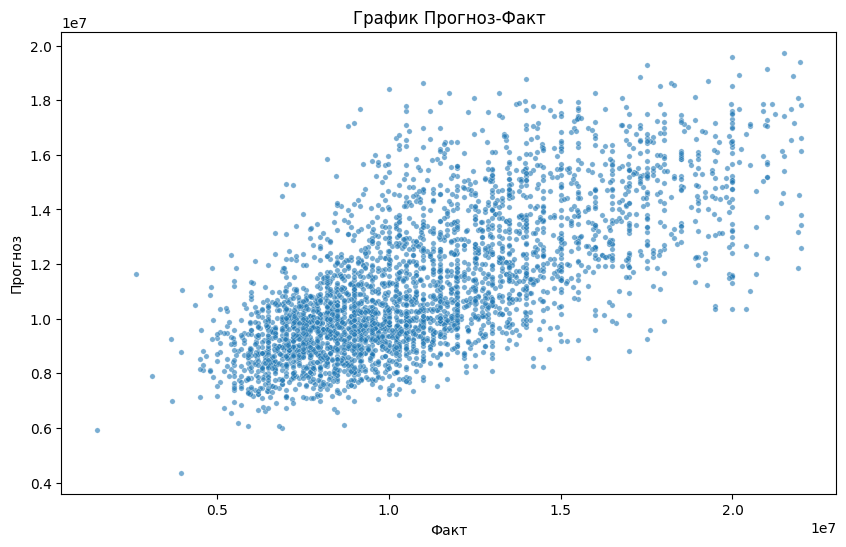

In [143]:
plot_prediction_fact (X_test_processed[:, np.array(union_features, dtype=int)], y_test, best_baies_model)

In [144]:
evaluation_results_optuna_selection = evaluate(best_baies_model, X_test_processed[:, np.array(union_features, dtype=int)], y_test)
evaluation_results_optuna_selection 

{'Среднее значение целевой переменной': 11079136.06,
 'Средний модуль ошибки': 2115935.8,
 'Средняя квадратичная ошибка': 7096293870351.13,
 'Коэффициент детерминации': 0.47,
 'Средняя абсолютная ошибка в процентах': 0.21,
 'Время предсказания в секундах': 0.003251791000366211}

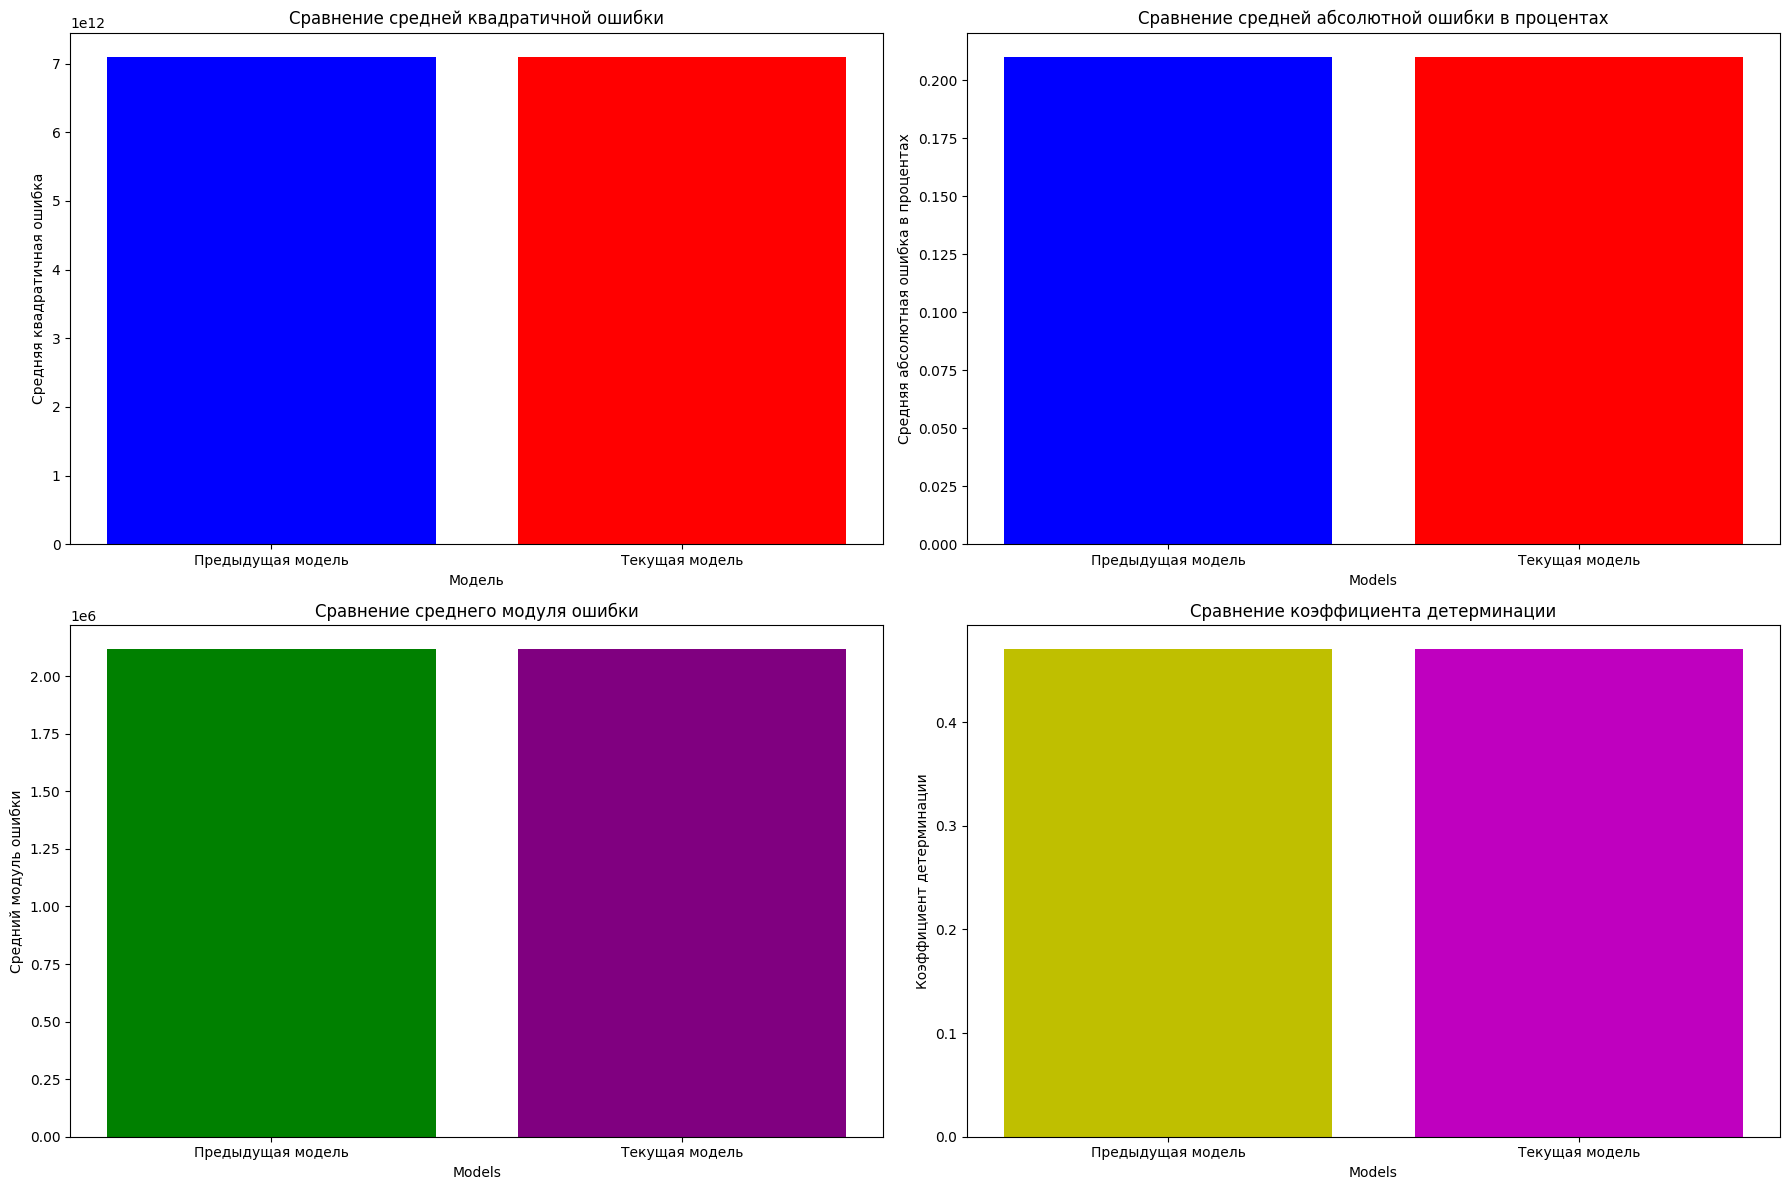

In [145]:
plot_error_comparison(evaluation_results_grid_selection, evaluation_results_optuna_selection)

<div class="alert alert-warning">
<h2> Комментарий ревьюера ⚠️</h2>

Что-то не пойму зачем везде по 2 одинаковых ячейки с одним и тем же кодом и метриками. 

И опять же, если видишь что повторяешь один и тот же код - нужно создать функцию и вызывать ее тогда когда нужно. Повторять код это плохой тон

</div>

Убрал все дубли, долой плохой тон!

In [147]:
#Логирование артефактов в MLflow

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    
pip_requirements = '../requirements.txt' # ваш код здесь
input_example = input_example = X_test[:10]# ваш код здесь
metadata = {'model_type': 'monthly'}# ваш код здесь

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.sklearn.log_model(best_baies_model,  artifact_path="models", pip_requirements=pip_requirements,
                             input_example=input_example, metadata=metadata,
                             registered_model_name=REGISTRY_MODEL_NAME, await_registration_for=6)
    # Дополнительные логгирования метрик и артефактов
    mlflow.log_metrics(evaluation_results_optuna_selection)
    mlflow.log_dict(params, "model_params.json")
    mlflow.log_params(best_params) 
    mlflow.log_artifact("columns.txt", artifact_path="dataframe")
    mlflow.log_artifact("flat_cleaned_churn", artifact_path="dataframe")


/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/mlflow/models/signature.py:333: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  input_schema = _infer_schema(input_ex)
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_mle-project-sprint-2-v001/lib/python3.10/site-packages/sklearn/base.py:458: UserWarn

Registered model 'optuna_selected_model' already exists. Creating a new version of this model...
2024/05/16 13:58:35 INFO mlflow.tracking._model_registry.client: Waiting up to 6 seconds for model version to finish creation. Model name: optuna_selected_model, version 2
Created version '2' of model 'optuna_selected_model'.


**ВЫВОД:**

После преобразований, Модель которая в базе была неплохой, не улучшила свои метрики, разве что стала быстрее обучаться. Лучшие метрики Модель демонстрировала при генерации новых фичей, ухудшение наступило после отбора параметров. Рискну предположить что могут быть следующие причины:

1. Недостаточно наблюдений, матрица корреляций не показала какие то приличные корреляции  с целевой переменной, такое ощущение что нехватало каких важных наблюдений, например близость к метро, вокзалам, паркам и пр. В принципе это возможно вычислить по координатам.

2. Неправильно подобрана модель. Возможно применив CatBoost результат получил бы лучше, но CatBoost насколько мне известно вообще прекрасен из коробки и примененные тут инструменты могут быть излишни.

3. Неправильно распределены и энкодированы фичи. Хотя я действительно по разному пробовал формировать.
